# Introduction

Using Big Data skills with DASK, specifically distributed cluster computing, along with supervised and unsupervised learning, I'm going to take a credit card transaction dataset from Kaggle at https://www.kaggle.com/ntnu-testimon/banksim1 and create a fraud detection model. This dataset is a synthetically created dataset designed to mimic real life credit card transactions. However, because it is a synthetic dataset, all the input features are available and labeled.

For my DASK cluster, I used the below physical hardware:

PC with Intel i7 quad core hyperthreading CPU (8 logical processors) and 16GB RAM

Windows 10 virtual machine on a Dell ESXi server with 2 Intel Xeon 10 core hyperthreading CPUs (40 logical processors) with 64GB RAM

Windows 10 virtual machine on a Dell ESXi server with 4 Intel Xeon 8 core hyperthreading CPUs (64 logical processors) with 640GB RAM

In [208]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import savetxt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, classification_report, confusion_matrix, make_scorer, roc_auc_score, roc_curve
from sklearn import metrics, tree, ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import joblib
import umap
import umap.plot
import category_encoders as ce

import dask.dataframe as dd
import dask.array as da
import joblib
from dask.distributed import Client, progress

from dask_ml.model_selection import HyperbandSearchCV
import dask_ml.model_selection as dcv
import dask_ml.cluster

In [256]:
#allow more rows to be displayed in each output window
pd.set_option('display.max_rows', 1000)

In [195]:
#connect to DASK scheduler for distributed computing
client = Client('100.118.35.87:8786')
client

Client Scheduler: tcp://100.118.35.87:8786 Dashboard: http://100.118.35.87:8787/status,Cluster Workers: 68 Cores: 68 Memory: 236.00 GB


In [5]:
#Function to visualize confusion matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [6]:
#read dataset from csv file in repo
data_df = pd.read_csv("bs140513_032310.csv")


In [7]:
#Convert all column names to lowercase
data_df.columns = map(str.lower, data_df.columns)

#Strip leading and trailing ' from strings
obj_columns = data_df.select_dtypes('object').columns

for col in obj_columns:
  data_df[col] = data_df[col].str.replace("'", '', regex=True)

# EDA Explore Data Types

In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeori   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipmerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


In [5]:
data_df.head()

,step,customer,age,gender,zipcodeori,merchant,zipmerchant,category,amount,fraud
0,0,C1093826151,4,M,28007,M348934600,28007,es_transportation,4.55,0
1,0,C352968107,2,M,28007,M348934600,28007,es_transportation,39.68,0
2,0,C2054744914,4,F,28007,M1823072687,28007,es_transportation,26.89,0
3,0,C1760612790,3,M,28007,M348934600,28007,es_transportation,17.25,0
4,0,C757503768,5,M,28007,M348934600,28007,es_transportation,35.72,0


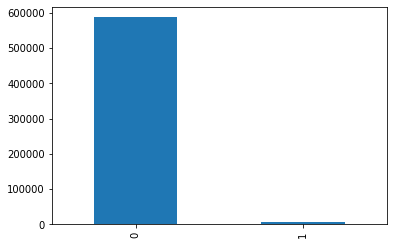

In [6]:
#fraud counts
data_df['fraud'].value_counts().plot(kind='bar')
plt.show()

In [7]:
#fraud counts
data_df['fraud'].value_counts()

0    587443
1      7200
Name: fraud, dtype: int64

# EDA Check Object Datatypes

In [8]:
features_df = data_df.copy()

In [9]:
#check categorical features
obj_columns = features_df.select_dtypes('object').columns

for col in obj_columns:
  if features_df[col].nunique() < 25:
    print(features_df[col].value_counts(),'\n')
  else:
    print(col, 'has',features_df[col].nunique(), 'values\n')

customer has 4112 values

2    187310
3    147131
4    109025
5     62642
1     58131
6     26774
0      2452
U      1178
Name: age, dtype: int64 

F    324565
M    268385
E      1178
U       515
Name: gender, dtype: int64 

28007    594643
Name: zipcodeori, dtype: int64 

merchant has 50 values

28007    594643
Name: zipmerchant, dtype: int64 

es_transportation        505119
es_food                   26254
es_health                 16133
es_wellnessandbeauty      15086
es_fashion                 6454
es_barsandrestaurants      6373
es_hyper                   6098
es_sportsandtoys           4002
es_tech                    2370
es_home                    1986
es_hotelservices           1744
es_otherservices            912
es_contents                 885
es_travel                   728
es_leisure                  499
Name: category, dtype: int64 



# EDA Check Object Datatypes

Age can be converted to integer if we change value U to 7 to denote unknown. zipcodeori and zipmerchant can both be changed to integer.

In [10]:
features_df.loc[(features_df.age == 'U'), 'age'] = '7'

features_df = features_df.astype({'age': int, 'zipcodeori': int, 'zipmerchant': int})

In [10]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  int32  
 3   gender       594643 non-null  object 
 4   zipcodeori   594643 non-null  int32  
 5   merchant     594643 non-null  object 
 6   zipmerchant  594643 non-null  int32  
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int32(3), int64(2), object(4)
memory usage: 38.6+ MB


# EDA Univariate Analysis

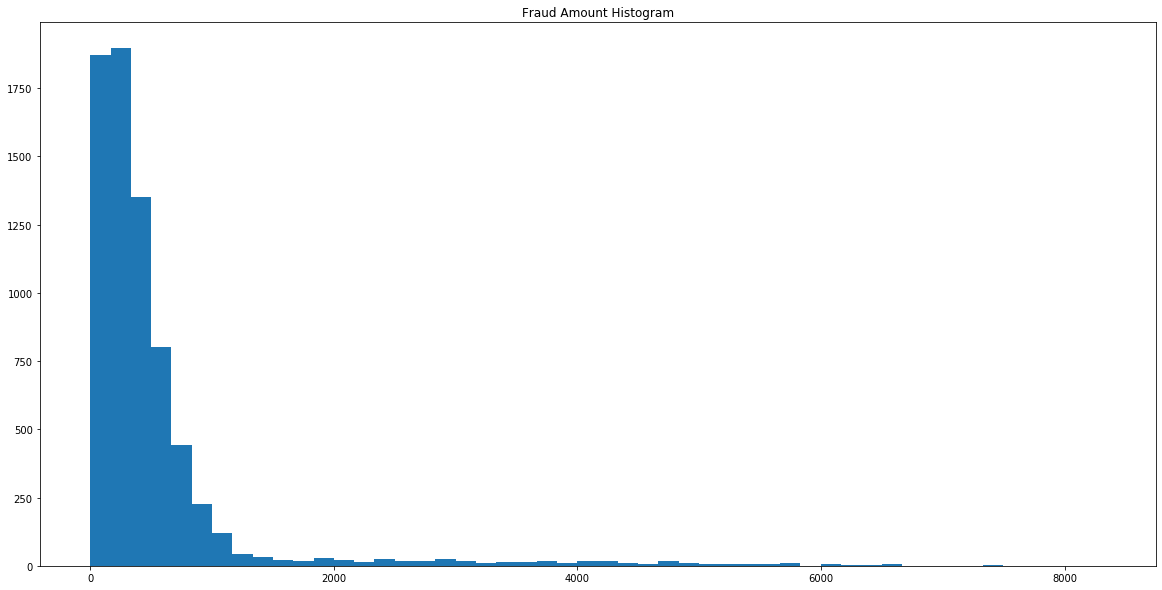

In [151]:
#histogram of all fraud transactions amount
plt.figure(figsize = (20,10))
plt.hist(features_df.loc[features_df['fraud'] == 1]['amount'], bins = 50)
plt.title('Fraud Amount Histogram')
plt.show()

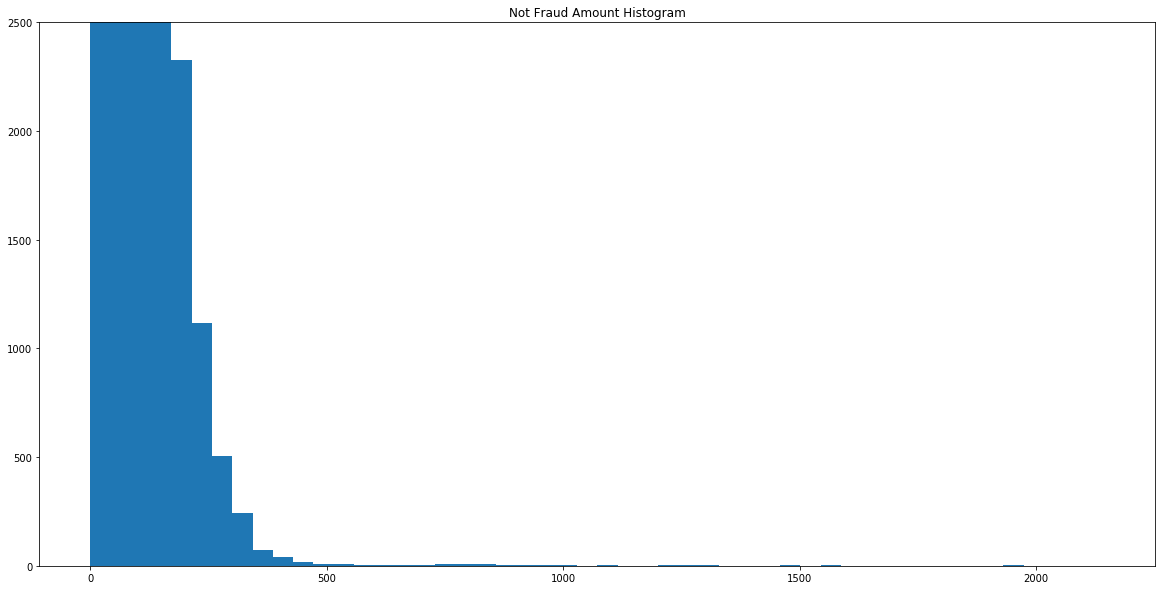

In [258]:
#histogram of all not fraud transaction amounts, limiting y axis to max 2500 in order to show lower histogram counts
plt.figure(figsize = (20,10))
plt.hist(features_df.loc[features_df['fraud'] == 0]['amount'], bins = 50)
plt.title('Not Fraud Amount Histogram')
plt.ylim(top=2500)
plt.show()

In [156]:
#amount statistics of the two fraud categories
features_df.groupby('fraud')['amount'].describe()

,count,mean,std,min,25%,50%,75%,max
fraud,,,,,,,,
0,587443.0,31.847230,31.470876,0.00,13.59,26.610,41.8950,2144.86
1,7200.0,530.926551,835.587112,0.03,159.98,319.175,548.9775,8329.96


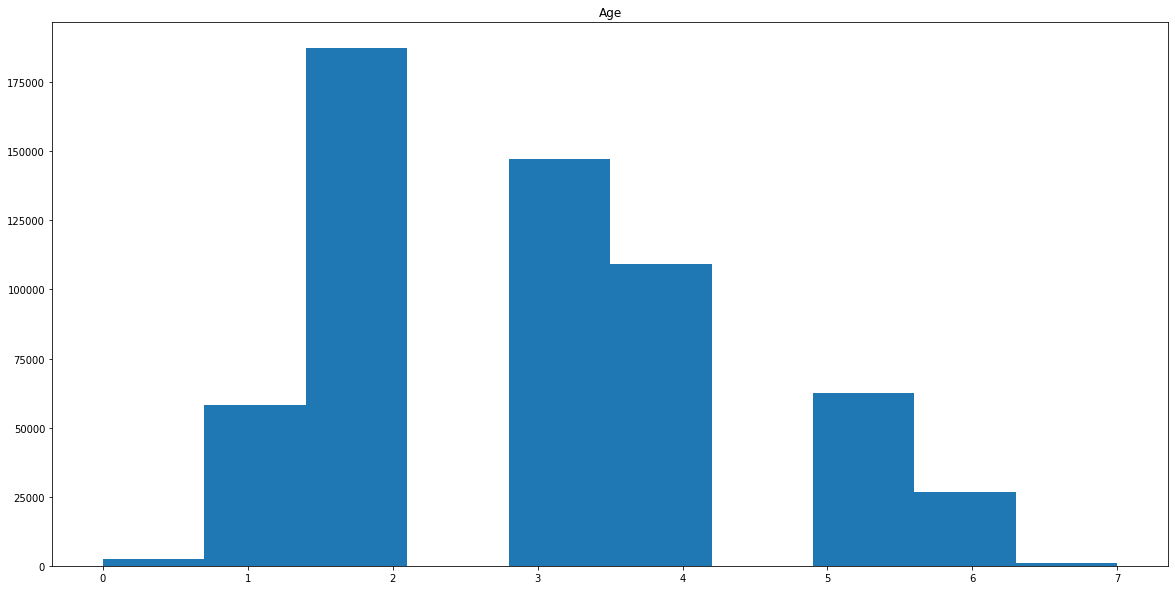

In [157]:
#histogram of age breakdown of dataset
plt.figure(figsize = (20,10))
plt.hist(features_df['age'])
plt.title('Age')
plt.show()

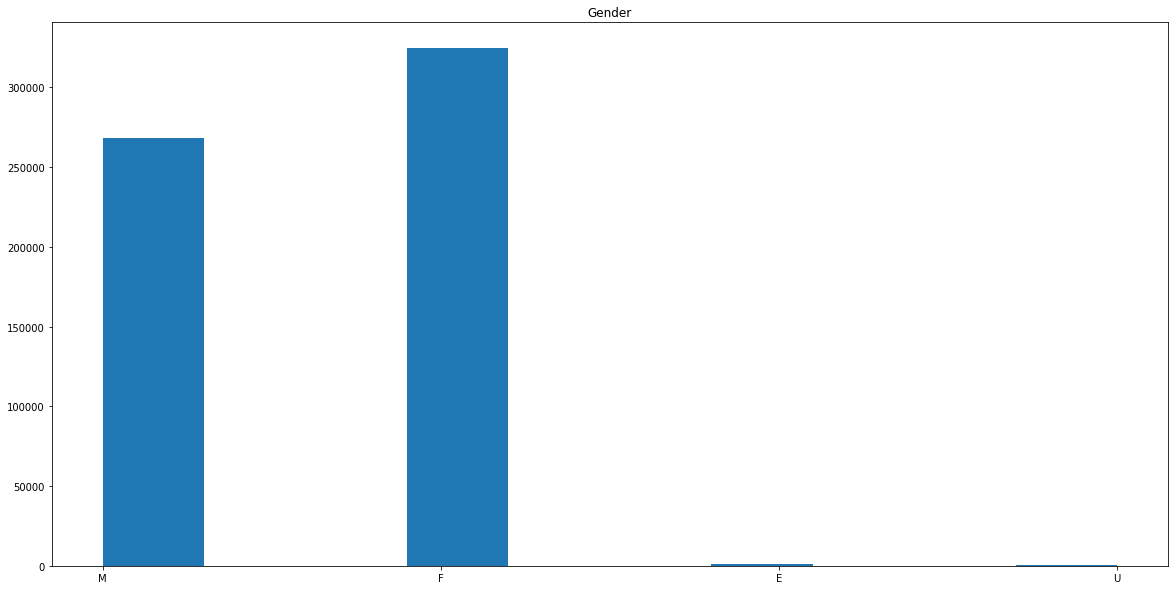

In [158]:
#histogram of gender breakdown
plt.figure(figsize = (20,10))
plt.hist(features_df['gender'])
plt.title('Gender')
plt.show()

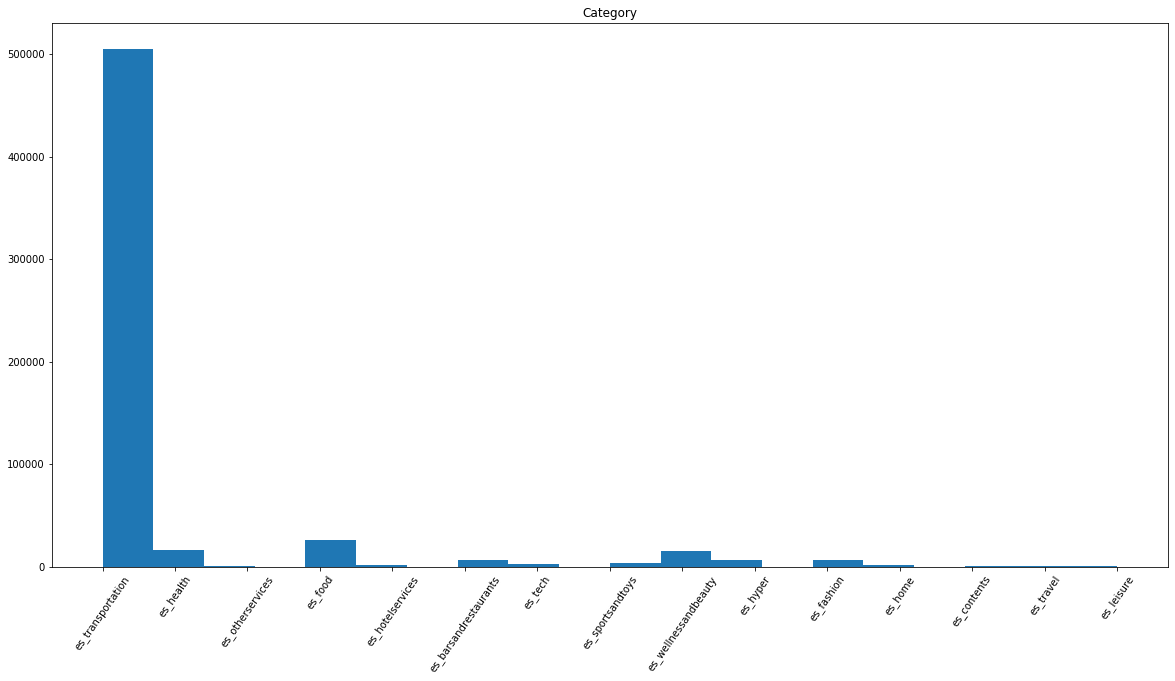

In [162]:
#histogram of category breakdown
plt.figure(figsize = (20,10))
plt.hist(features_df['category'], bins = 20)
plt.title('Category')
plt.xticks(rotation = 55)
plt.show()

# EDA Multivariate Analysis

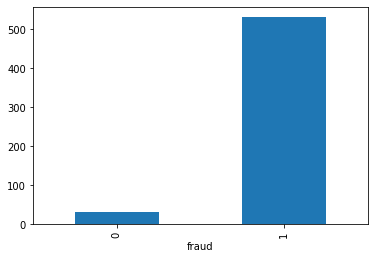

In [12]:
#Mean amount of each fraud transaction type
features_df.groupby('fraud')['amount'].mean().plot(kind='bar')
plt.show()

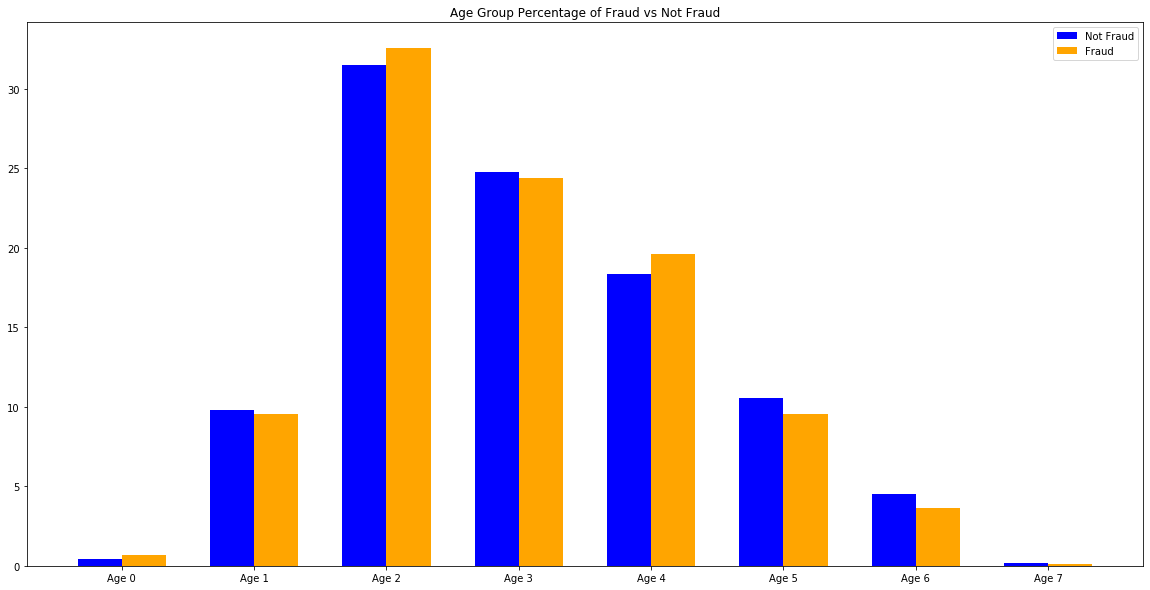

In [13]:
#Fraud breakdown by percentage for each age group
x = 0.5
plt.figure(figsize=(20,10))
for n in range(8):
  #plot percentage values instead of raw values
  plt.bar(x, (features_df.loc[(features_df['age'] == n) & (features_df['fraud'] == 0)]['fraud'].count())/features_df.loc[features_df['fraud'] == 0, 'fraud'].count()*100, width=0.5, color='blue')
  plt.bar(x + 0.5, (features_df.loc[(features_df['age'] == n) & (features_df['fraud'] == 1)]['fraud'].count())/features_df.loc[features_df['fraud'] == 1, 'fraud'].count()*100, width=0.5, color='orange')
  x += 1.5

plt.title('Age Group Percentage of Fraud vs Not Fraud')
plt.xticks(np.arange(0.75, 12, 1.5), ['Age 0', 'Age 1', 'Age 2', 'Age 3', 'Age 4', 'Age 5', 'Age 6', 'Age 7'])
plt.legend(['Not Fraud', 'Fraud'])
plt.show()

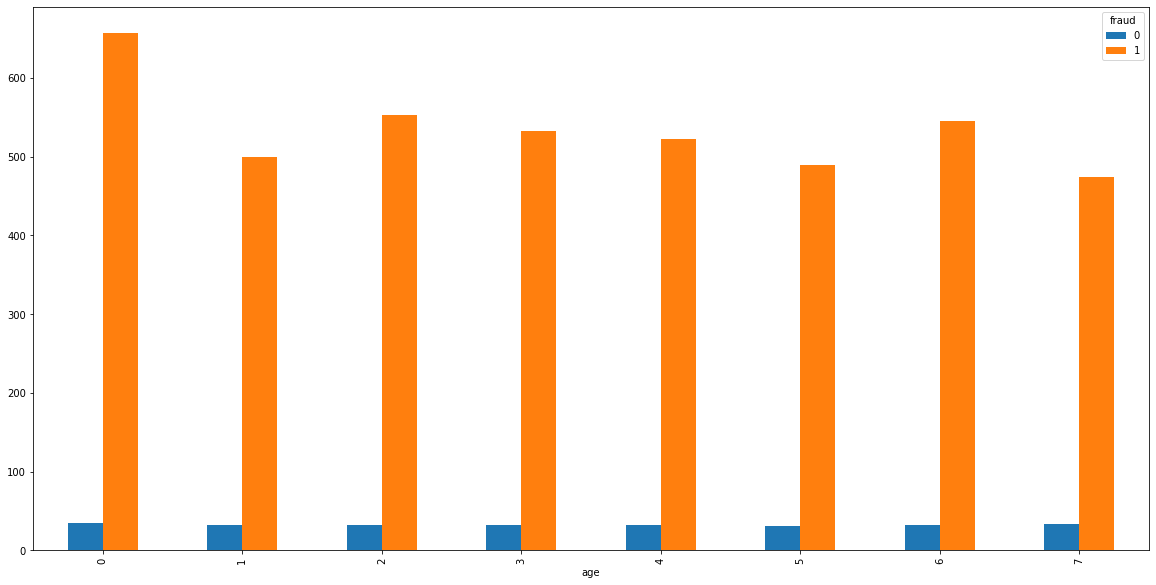

count        mean         std     min       25%      50%  \
age fraud                                                                
0   0        2404.0   34.409713   38.187648    0.02   14.3425   27.880   
    1          48.0  657.278125  806.467000   55.78  262.0725  400.785   
1   0       57442.0   31.986634   32.629816    0.00   13.4700   26.630   
    1         689.0  499.757692  822.697223    0.80  135.5300  304.650   
2   0      184966.0   31.846593   31.911817    0.00   13.6500   26.650   
    1        2344.0  552.212432  927.895106    1.03  152.8375  312.095   
3   0      145376.0   31.909451   31.852309    0.00   13.5600   26.660   
    1        1755.0  532.428758  796.917630    0.03  173.1800  325.580   
4   0      107615.0   31.857414   31.299433    0.00   13.5500   26.600   
    1        1410.0  522.400915  768.175643    1.17  174.1775  326.695   
5   0       61956.0   31.410537   28.504940    0.00   13.5600   26.360   
    1         686.0  489.418017  719.075535    0.11  141.9750  314.180   
6   0       26513.0   31.859470   30.061913    0.00   13.6700   26.540   
    1         261.0  545.402682  896.023741    3.27  175.4500  298.440   
7   0        1171.0   34.016336   36.233926    0.00   13.0650   27.190   
    1           7.0  473.458571  339.008999  197.14  316.2300  371.840   

                75%      max  
age fraud                     
0   0       43.4625   990.17  
    1      587.8675  4170.56  
1   0       41.8800  1559.55  
    1      504.4100  7134.39  
2   0       41.8375  2144.86  
    1      552.5425  8329.96  
3   0       41.9900  1953.05  
    1      551.9550  6679.23  
4   0       42.0200  1993.68  
    1      562.9225  6260.89  
5   0       41.5800   656.17  
    1      545.3400  6590.61  
6   0       41.9100   852.08  
    1      503.5000  7432.48  
7   0       42.1200   406.41  
    1      448.5700  1215.63

In [14]:
#Mean amount of transactions by age group and fraud transaction types
features_df.groupby(['age', 'fraud'])['amount'].mean().unstack().plot(kind='bar', figsize=(20,10))
plt.show()

#statistics of amount by age group and fraud type
features_df.groupby(['age', 'fraud'])['amount'].describe()

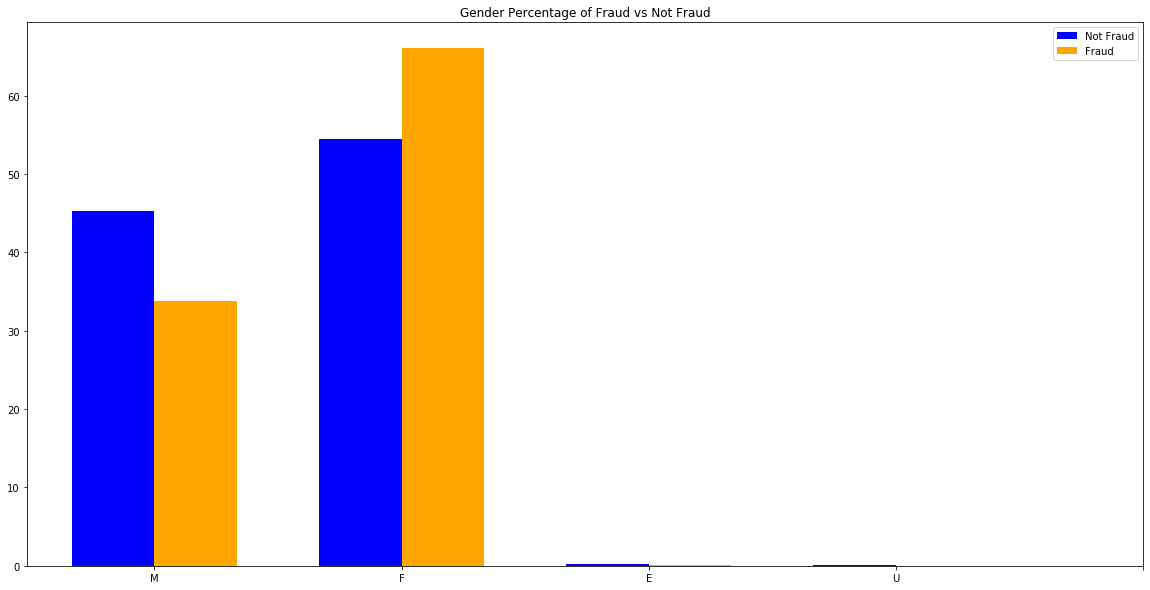

In [15]:
#Fraud breakdown by gender
x = 0.5
plt.figure(figsize=(20,10))
for gender in features_df['gender'].unique():
  plt.bar(x, (features_df.loc[(features_df['gender'] == gender) & (features_df['fraud'] == 0)]['fraud'].count())/features_df.loc[features_df['fraud'] == 0, 'fraud'].count()*100, width=0.5, color='blue')
  plt.bar(x + 0.5, (features_df.loc[(features_df['gender'] == gender) & (features_df['fraud'] == 1)]['fraud'].count())/features_df.loc[features_df['fraud'] == 1, 'fraud'].count()*100, width=0.5, color='orange')
  x += 1.5

plt.title('Gender Percentage of Fraud vs Not Fraud')
plt.legend(['Not Fraud', 'Fraud'])
plt.xticks(np.arange(0.75, 8, 1.5), features_df['gender'].unique().tolist())
plt.show()

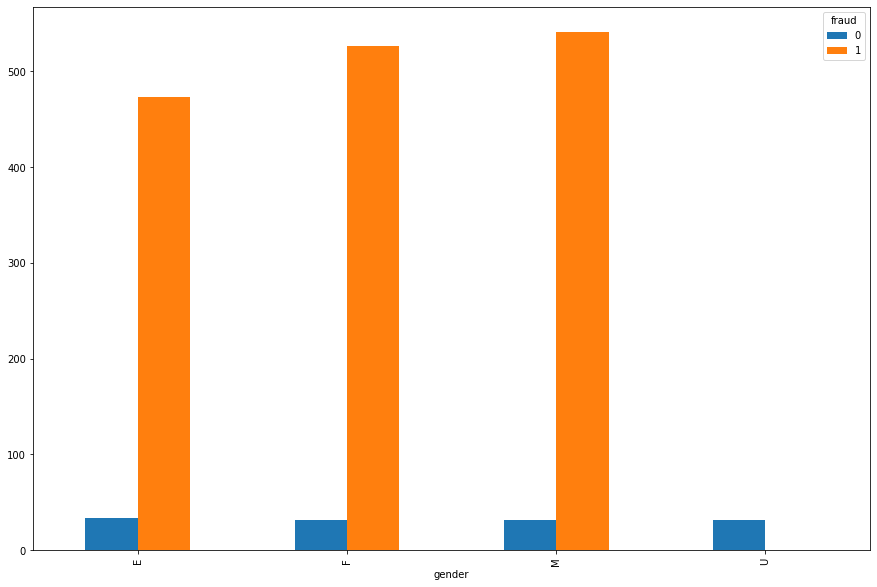

count        mean         std     min       25%      50%  \
gender fraud                                                                
E      0        1171.0   34.016336   36.233926    0.00   13.0650   27.190   
       1           7.0  473.458571  339.008999  197.14  316.2300  371.840   
F      0      319807.0   31.968111   31.509230    0.00   13.6500   26.650   
       1        4758.0  526.178188  833.233871    0.03  158.1375  318.805   
M      0      265950.0   31.692975   31.400433    0.00   13.5200   26.580   
       1        2435.0  540.370078  841.278641    0.04  163.8900  319.960   
U      0         515.0   31.508932   31.914246    0.11   11.3800   25.150   

                   75%      max  
gender fraud                     
E      0       42.1200   406.41  
       1      448.5700  1215.63  
F      0       41.9400  2144.86  
       1      549.0125  7665.56  
M      0       41.8400  1993.68  
       1      550.0200  8329.96  
U      0       42.6300   306.80

In [16]:
#Mean amount of transactions by gender and fraud transaction types
features_df.groupby(['gender', 'fraud'])['amount'].mean().unstack().plot(kind='bar', figsize=(15,10))
plt.show()

#statistics of amount by gender and fraud transaction types
features_df.groupby(['gender', 'fraud'])['amount'].describe()

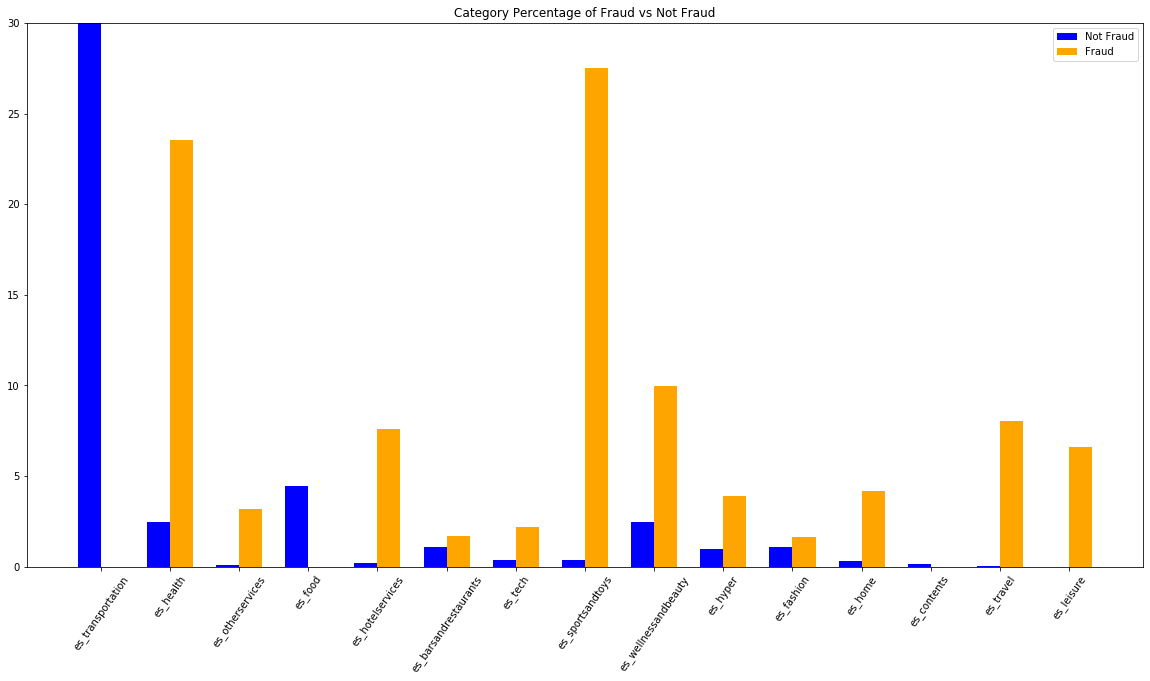

In [17]:
#Fraud breakdown by category
x = 0.5
plt.figure(figsize=(20,10))
for category in features_df['category'].unique():
  plt.bar(x, (features_df.loc[(features_df['category'] == category) & (features_df['fraud'] == 0)]['fraud'].count())/features_df.loc[features_df['fraud'] == 0, 'fraud'].count()*100, width=0.5, color='blue')
  plt.bar(x + 0.5, (features_df.loc[(features_df['category'] == category) & (features_df['fraud'] == 1)]['fraud'].count())/features_df.loc[features_df['fraud'] == 1, 'fraud'].count()*100, width=0.5, color='orange')
  x += 1.5

plt.title('Category Percentage of Fraud vs Not Fraud')
plt.legend(['Not Fraud', 'Fraud'])
plt.xticks(np.arange(0.75, 22, 1.5), features_df['category'].unique().tolist(), rotation=55)
plt.ylim(top=30)
plt.show()

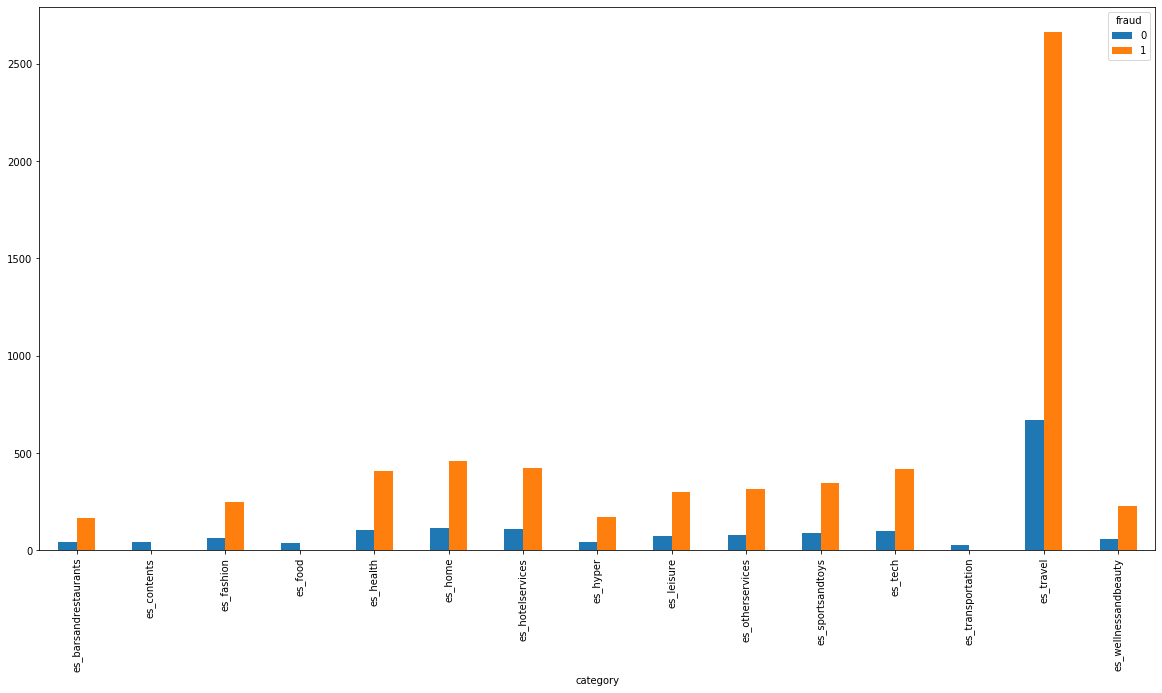

count         mean          std    min  \
category              fraud                                              
es_barsandrestaurants 0        6253.0    41.145997    29.556990   0.01   
                      1         120.0   164.092667   134.609429   2.37   
es_contents           0         885.0    44.547571    33.155431   0.01   
es_fashion            0        6338.0    62.347674    44.366965   0.01   
                      1         116.0   247.008190   174.700219   4.35   
es_food               0       26254.0    37.070405    24.998969   0.00   
es_health             0       14437.0   103.737228    76.868889   0.07   
                      1        1696.0   407.031338   300.950780   0.03   
es_home               0        1684.0   113.338409    83.258225   0.13   
                      1         302.0   457.484834   324.455791   0.19   
es_hotelservices      0        1196.0   106.548545    69.366818   0.02   
                      1         548.0   421.823339   288.523734   0.41   
es_hyper              0        5818.0    40.037145    27.960813   0.02   
                      1         280.0   169.255429   114.147915   1.13   
es_leisure            0          25.0    73.230400    21.344153  38.74   
                      1         474.0   300.286878    83.991186  45.46   
es_otherservices      0         684.0    75.685497    54.630466   0.06   
                      1         228.0   316.469605   219.836845   7.66   
es_sportsandtoys      0        2020.0    88.502738    63.143463   0.11   
                      1        1982.0   345.366811   237.826983   0.42   
es_tech               0        2212.0    99.924638    73.504809   0.09   
                      1         158.0   415.274114   272.119410   9.71   
es_transportation     0      505119.0    26.958187    17.527878   0.00   
es_travel             0         150.0   669.025533   496.562334   0.47   
                      1         578.0  2660.802872  1736.114452   7.40   
es_wellnessandbeauty  0       14368.0    57.320219    41.478691   0.02   
                      1         718.0   229.422535   165.192660   0.04   

                                   25%       50%        75%      max  
category              fraud                                           
es_barsandrestaurants 0        16.8800    35.800    60.3300   166.81  
                      1        62.8825   135.960   218.5100   695.63  
es_contents           0        17.5000    38.430    65.2000   185.13  
es_fashion            0        26.4125    54.870    89.9800   269.39  
                      1       119.4250   224.685   349.4150   773.61  
es_food               0        16.9625    33.475    53.5100   154.91  
es_health             0        41.6400    89.110   151.0100   468.81  
                      1       164.3000   353.365   585.6925  1972.81  
es_home               0        48.1825    97.710   159.9475   523.11  
                      1       204.1650   391.670   653.4025  1540.23  
es_hotelservices      0        49.0000   100.385   154.2775   345.87  
                      1       193.1150   382.490   616.0600  1429.04  
es_hyper              0        17.4525    35.415    57.8575   168.94  
                      1        67.7450   163.785   241.8875   488.02  
es_leisure            0        58.8600    73.310    86.6500   120.92  
                      1       245.0975   300.590   357.0450   592.03  
es_otherservices      0        30.0850    65.795   111.5425   298.81  
                      1       150.9525   272.175   436.3900   964.30  
es_sportsandtoys      0        36.0075    78.735   129.6975   374.46  
                      1       150.2950   311.420   507.0700  1258.33  
es_tech               0        41.0675    84.225   146.8725   454.83  
                      1       203.8250   364.430   583.2400  1305.35  
es_transportation     0        12.8000    24.960    38.6400   118.07  
es_travel             0       272.3450   601.885   918.9125  2144.86  
                      1      1276.5225 

In [18]:
#Mean amount of transactions by category and fraud transaction types
features_df.groupby(['category', 'fraud'])['amount'].mean().unstack().plot(kind='bar', figsize=(20,10))
plt.show()

#statistics of amount by category and fraud transaction types
features_df.groupby(['category', 'fraud'])['amount'].describe()

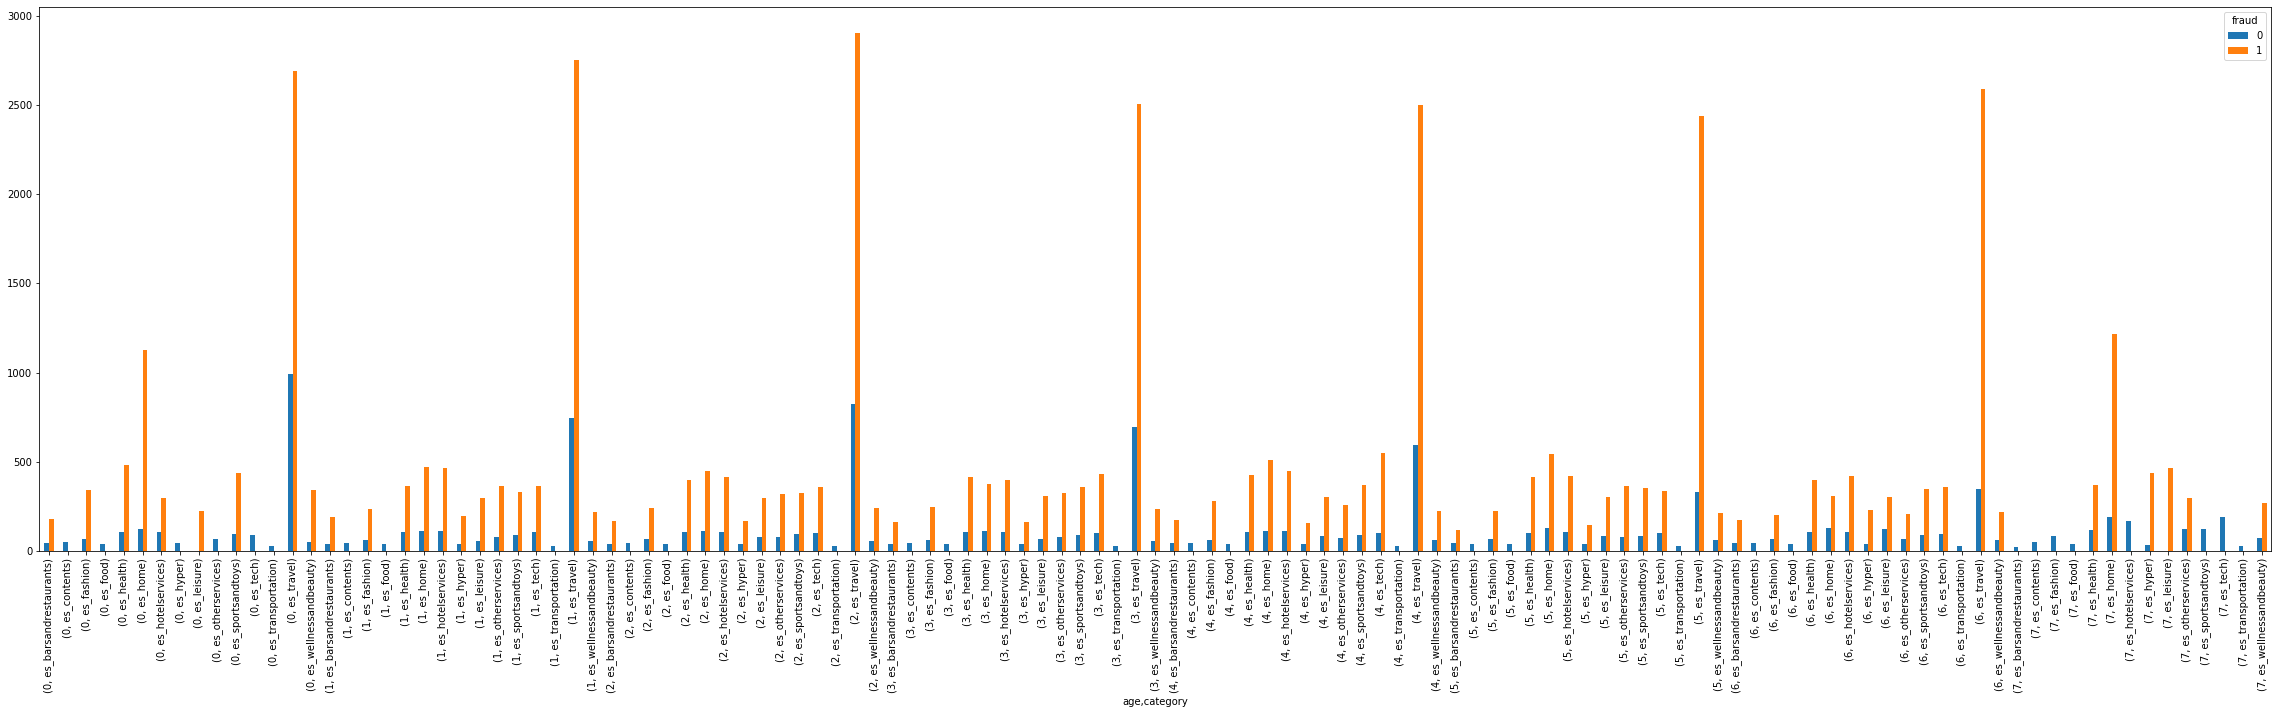

In [175]:
#Mean amount of transactions by age, category and fraud transaction types
features_df.groupby(['age', 'category', 'fraud'])['amount'].mean().unstack().plot(kind='bar', figsize=(40,10))
plt.show()

In [176]:
features_df.groupby(['age', 'category', 'fraud'])['amount'].describe()

count         mean          std      min  \
age category              fraud                                                
0   es_barsandrestaurants 0          31.0    45.013548    28.298110     6.98   
                          1           1.0   180.200000          NaN   180.20   
    es_contents           0           4.0    46.602500    15.962831    23.95   
    es_fashion            0          37.0    67.724865    48.098081     0.02   
                          1           1.0   340.200000          NaN   340.20   
    es_food               0         123.0    35.633821    23.734170     0.08   
    es_health             0         102.0   105.379902    80.046385     0.13   
                          1          11.0   482.875455   222.548704   200.13   
    es_home               0          10.0   119.995000    90.046011     8.25   
                          1           2.0  1125.160000    59.425254  1083.14   
    es_hotelservices      0           3.0   104.800000    45.664403    52.08   
                          1           2.0   295.410000    39.131289   267.74   
    es_hyper              0          25.0    44.810800    29.799070     1.79   
    es_leisure            1           5.0   221.734000   112.394508    93.08   
    es_otherservices      0           8.0    66.952500    50.796006     8.94   
    es_sportsandtoys      0           4.0    94.150000    73.470400    17.17   
                          1          12.0   438.224167   213.238055   111.47   
    es_tech               0          16.0    87.395625    68.178385     5.82   
    es_transportation     0        1960.0    27.332827    17.453782     0.03   
    es_travel             0           1.0   990.170000          NaN   990.17   
                          1           5.0  2692.180000  1091.915293  1451.61   
    es_wellnessandbeauty  0          80.0    49.923875    40.979352     1.15   
                          1           9.0   338.657778   174.487842    55.78   
1   es_barsandrestaurants 0         592.0    39.271402    28.213055     0.23   
                          1          14.0   189.157143   178.677297    45.20   
    es_contents           0          99.0    45.569091    36.368743     1.10   
    es_fashion            0         604.0    60.779172    46.285521     0.01   
                          1           9.0   235.443333   175.461270     4.35   
    es_food               0        2589.0    37.473847    24.501986     0.01   
    es_health             0        1518.0   104.917029    76.797339     0.07   
                          1         158.0   365.592342   325.227527     3.63   
    es_home               0         171.0   112.281520    82.161891     1.58   
                          1          25.0   472.241600   366.517339    16.15   
    es_hotelservices      0         120.0   113.214583    69.699433     0.09   
                          1          58.0   464.887241   312.840076     0.80   
    es_hyper              0         515.0    38.924466    28.027010     0.11   
                          1          26.0   195.488846   144.564828    10.77   
    es_leisure            0           4.0    56.932500    12.842472    46.41   
                          1          54.0   295.745926    94.972597    87.35   
    es_otherservices      0          56.0    78.595357    51.340522     1.47   
                          1          33.0   363.416364   188.143837    28.14   
    es_sportsandtoys      0         192.0    87.033802    63.165821     0.57   
                          1         185.0   327.895189   243.909792     6.11   
    es_tech               0         224.0   102.813259    80.663236     0.11   
                          1          16.0   360.982500   251.044799    64.27   
    es_transportation     0       49455.0    26.943140    17.563817     0.00   
    es_travel             0          18.0   745.173889   427.304054     9.84   
                          1          47.0  2755.805745  1886.201990   181.00   
    es_wellnessandbeauty  0        1

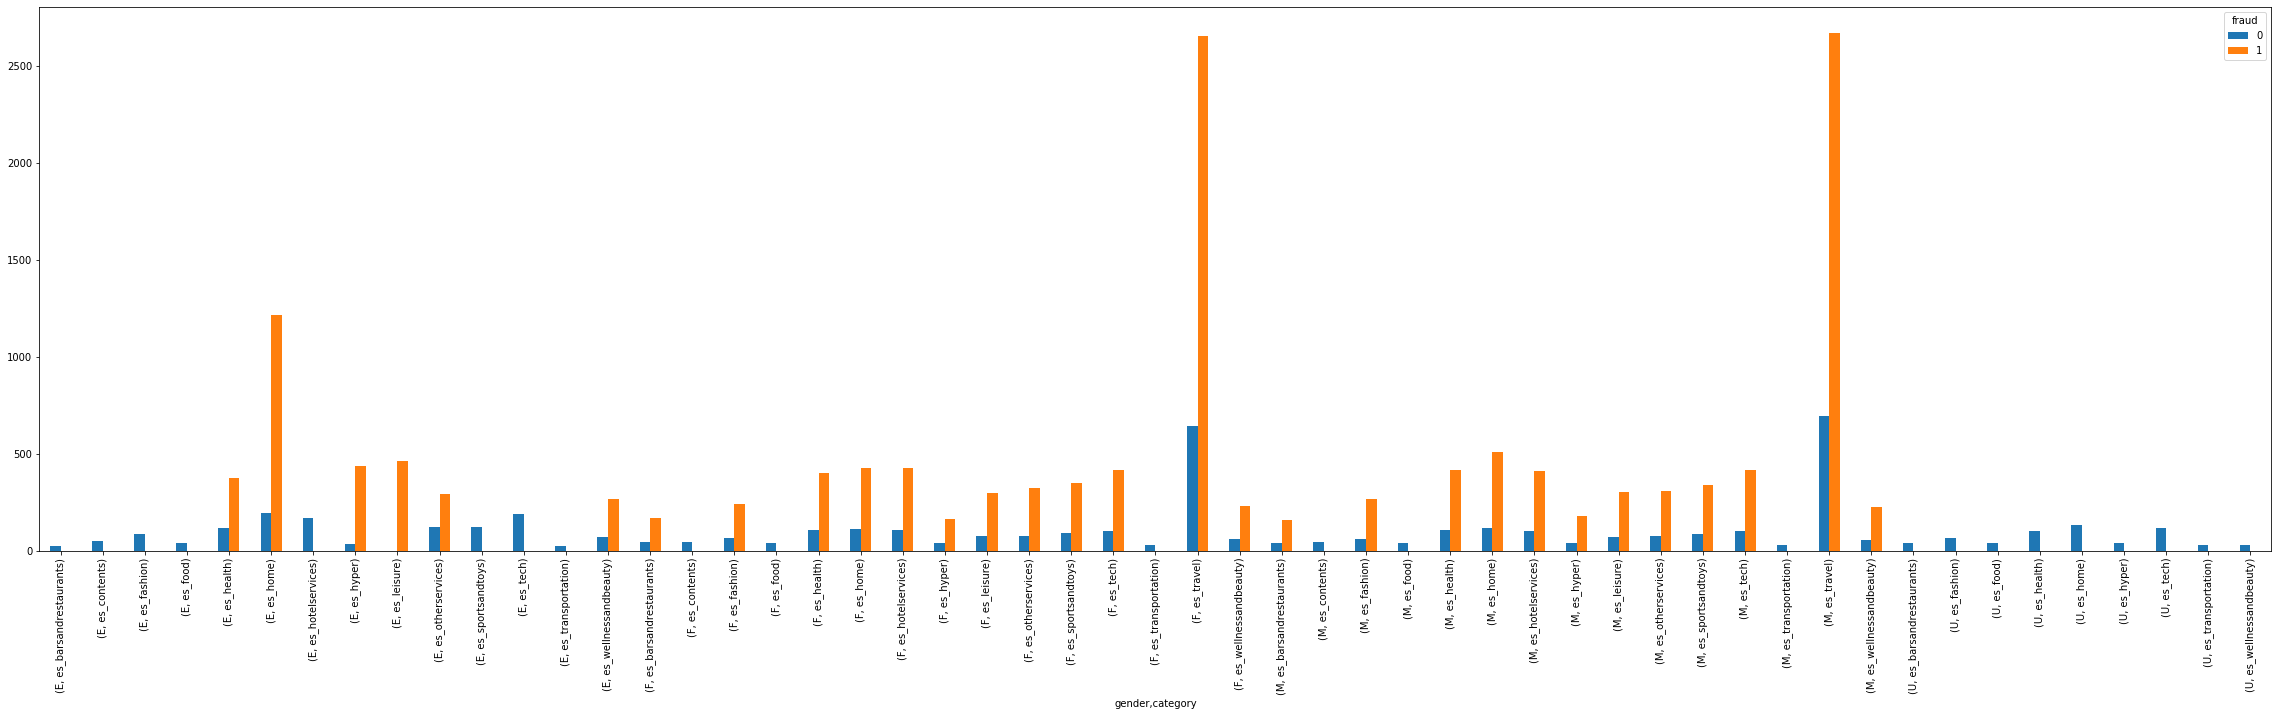

In [177]:
#Mean amount of transactions by age, category, and fraud transaction types
features_df.groupby(['gender', 'category', 'fraud'])['amount'].mean().unstack().plot(kind='bar', figsize=(40,10))
plt.show()

In [178]:
features_df.groupby(['gender', 'category', 'fraud'])['amount'].describe()

count         mean          std  \
gender category              fraud                                       
E      es_barsandrestaurants 0          14.0    22.391429    23.108813   
       es_contents           0           4.0    47.820000    28.284103   
       es_fashion            0          12.0    82.951667    74.450264   
       es_food               0          64.0    38.338437    24.526696   
       es_health             0          45.0   114.042889    62.829493   
                             1           1.0   371.840000          NaN   
       es_home               0           1.0   191.670000          NaN   
                             1           1.0  1215.630000          NaN   
       es_hotelservices      0           8.0   167.066250    77.230453   
       es_hyper              0          13.0    34.704615    21.566623   
                             1           1.0   434.170000          NaN   
       es_leisure            1           1.0   462.970000          NaN   
       es_otherservices      0           1.0   120.780000          NaN   
                             1           1.0   294.200000          NaN   
       es_sportsandtoys      0           4.0   124.082500    25.726963   
       es_tech               0           7.0   190.275714   117.235886   
       es_transportation     0         975.0    25.805405    16.975621   
       es_wellnessandbeauty  0          23.0    72.116957    44.949558   
                             1           2.0   267.700000    99.786909   
F      es_barsandrestaurants 0        3457.0    41.783888    30.170481   
                             1          81.0   167.994568   145.799795   
       es_contents           0         446.0    45.368677    32.457283   
       es_fashion            0        3528.0    62.843614    44.594510   
                             1          84.0   240.481548   170.242401   
       es_food               0       14321.0    37.283734    25.089754   
       es_health             0        8177.0   103.802423    77.324103   
                             1        1111.0   401.207084   294.361016   
       es_home               0         928.0   111.906735    82.044235   
                             1         195.0   425.209795   299.631769   
       es_hotelservices      0         642.0   108.591682    69.347718   
                             1         360.0   427.955167   294.700387   
       es_hyper              0        3157.0    40.119987    27.970652   
                             1         189.0   163.450635   115.856968   
       es_leisure            0          13.0    77.453077    18.778785   
                             1         309.0   298.848706    83.970782   
       es_otherservices      0         363.0    74.871515    55.676377   
                             1         141.0   322.481135   216.772007   
       es_sportsandtoys      0        1137.0    89.870237    63.216504   
                             1        1305.0   349.047249   241.132156   
       es_tech               0        1196.0    99.745284    72.683754   
                             1         102.0   416.414412   282.197850   
       es_transportation     0      274454.0    26.958997    17.520815   
       es_travel             0          78.0   644.880000   504.420451   
                             1         378.0  2655.217249  1753.168314   
       es_wellnessandbeauty  0        7910.0    57.560924    41.645351   
                             1         503.0   231.943658   167.290260   
M      es_barsandrestaurants 0        2779.0    40.448949    28.772234   
                             1          39.0   155.988718   109.044073   
       es_contents           0         435.0    43.675609    33.938651   
       es_fashion            0        2792.0    61.632636    43.915563   
                             1          32.0   264.140625   187.625479   
       es_food               0       11843.0    36.806356    24.898452   
       es_health             0        6194.

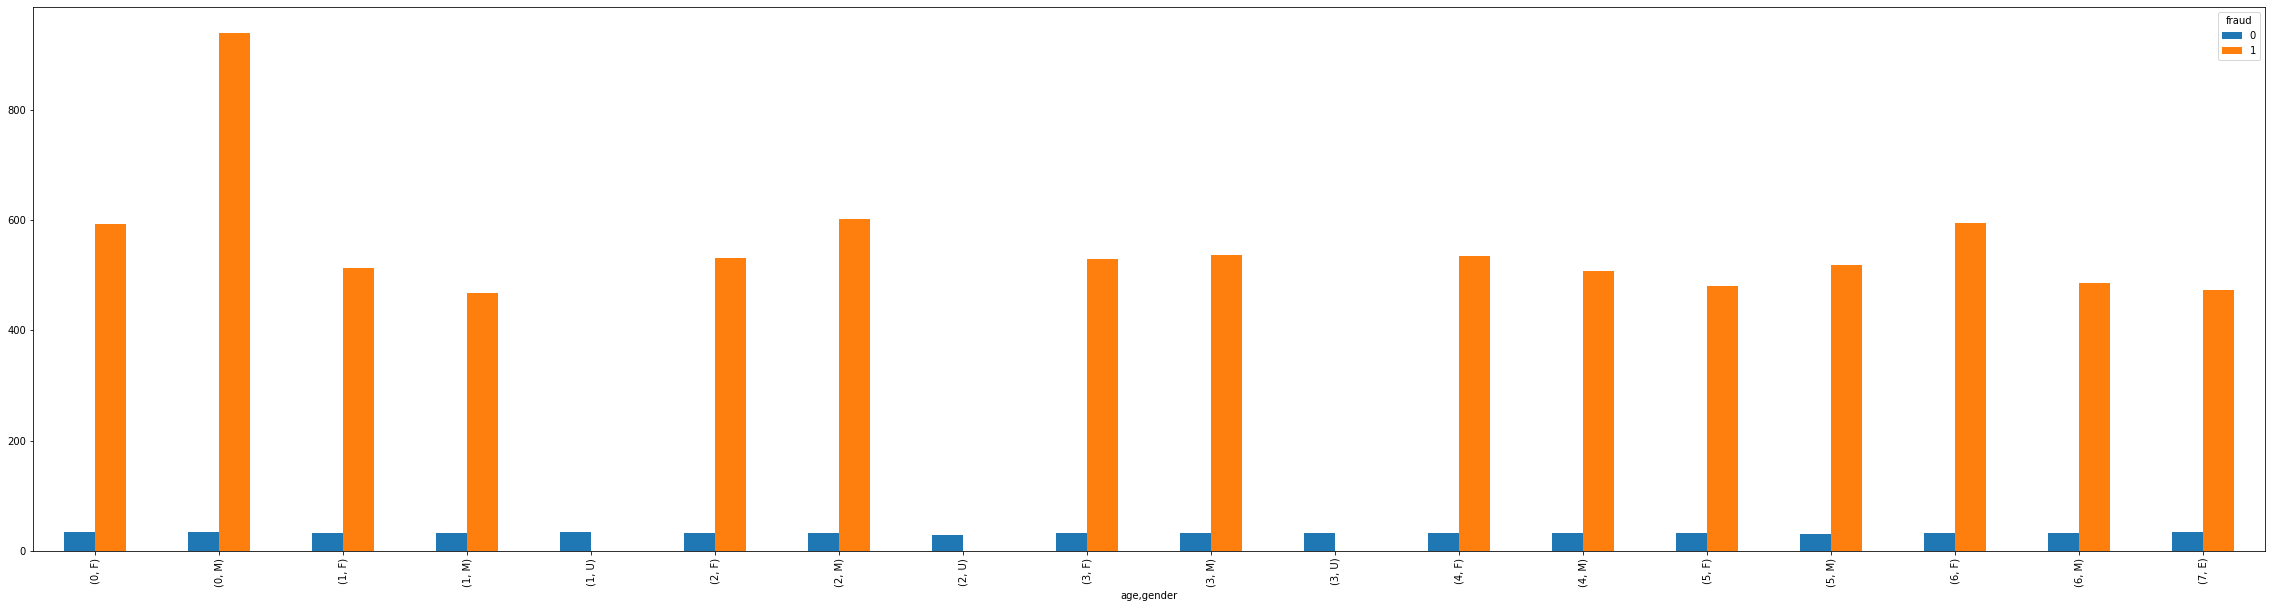

count        mean          std     min       25%  \
age gender fraud                                                        
0   F      0        1818.0   34.748460    40.144249    0.02   14.3875   
           1          39.0  592.275128   765.557474   55.78  256.4050   
    M      0         586.0   33.358788    31.357457    0.04   13.8900   
           1           9.0  938.957778   962.966102  180.20  416.5600   
1   F      0       32340.0   32.091313    31.751640    0.00   13.7100   
           1         496.0  512.469577   849.194309    0.80  138.5650   
    M      0       24924.0   31.841895    33.744748    0.01   13.2475   
           1         193.0  467.088808   751.434649    3.63  129.2100   
    U      0         178.0   33.234719    31.303144    0.24   12.1675   
2   F      0      103112.0   32.144782    32.794721    0.00   13.7175   
           1        1642.0  531.235445   871.292620    1.03  149.7425   
    M      0       81690.0   31.476270    30.764806    0.00   13.5800   
           1         702.0  601.278262  1047.460698    4.49  156.2775   
    U      0         164.0   28.827317    28.039195    0.47   10.5775   
3   F      0       77333.0   31.973974    32.171328    0.00   13.4800   
           1        1099.0  529.469345   815.444013    0.03  169.0600   
    M      0       67870.0   31.834999    31.474501    0.00   13.6300   
           1         656.0  537.386677   765.463107    0.04  182.1150   
    U      0         173.0   32.275376    35.773653    0.11   11.5500   
4   F      0       57835.0   31.743270    29.739877    0.00   13.6600   
           1         811.0  534.043736   808.971839    1.17  176.3900   
    M      0       49780.0   31.990029    33.018777    0.00   13.4100   
           1         599.0  506.637429   709.574639    1.68  171.7150   
5   F      0       33574.0   31.465126    28.462271    0.00   13.5200   
           1         527.0  480.775825   706.370029    0.11  135.6300   
    M      0       28382.0   31.345961    28.555698    0.00   13.5800   
           1         159.0  518.062264   761.289052    0.95  187.1100   
6   F      0       13795.0   32.126254    30.306832    0.01   13.9500   
           1         144.0  594.572500  1034.035803    3.27  187.1450   
    M      0       12718.0   31.570094    29.792467    0.00   13.3825   
           1         117.0  484.885983   688.994116   15.76  153.4700   
7   E      0        1171.0   34.016336    36.233926    0.00   13.0650   
           1           7.0  473.458571   339.008999  197.14  316.2300   

                      50%        75%      max  
age gender fraud                               
0   F      0       27.960    43.4675   990.17  
           1      370.280   565.3650  4170.56  
    M      0       27.435    43.3225   316.39  
           1      541.880  1083.1400  3132.69  
1   F      0       26.690    41.9500  1308.68  
           1      320.135   528.0375  7134.39  
    M      0       26.570    41.7800  1559.55  
           1      297.920   470.2200  5772.54  
    U      0       27.350    44.4000   224.23  
2   F      0       26.730    41.9800  2144.86  
           1      308.520   554.3650  7665.56  
    M      0       26.550    41.6800  1954.73  
           1      315.085   546.6225  8329.96  
    U      0       22.215    39.8750   261.38  
3   F      0       26.630    42.0100  1953.05  
           1      321.460   542.9900  6679.23  
    M      0       26.690    41.9600  1483.26  
           1      333.930   569.3025  5749.28  
    U      0       25.720    41.0700   306.80  
4   F      0       26.620    41.8400  1120.37  
           1      333.190   565.9250  6260.89  
    M      0       26.590    42.2300  1993.68  
           1      315.920   559.7050  5646.51  
5   F      0       26.350    41.7300   537.95  
           1      306.040   534.9650  6590.61  
    M      0       26.405    41.3700   656.17  
           1      328.660   576.9950  6142.59  
6   F      0       26.750    41.9600   852.08  
           1      302.270

In [21]:
#Mean amount of transactions by age, gender, and fraud transaction types
features_df.groupby(['age', 'gender', 'fraud'])['amount'].mean().unstack().plot(kind='bar', figsize=(40,10))
plt.show()
features_df.groupby(['age', 'gender', 'fraud'])['amount'].describe()

## EDA

Based on the above EDA, I expect the amount of the transaction followed by the transaction category to be high indicators of fraud transactions.

# Feature Engineering 

## Customer categorical feature

Customer feature has 4112 unique values and merchant has 50 unique values. I don't want to drop these features so I will use binary encoding instead of one hot encoding to reduce total amount of dimensions.

In [11]:
#drop zipcodeori and zipmerhant features as these are identical for both features and all rows
data_df = features_df.drop(['zipcodeori', 'zipmerchant'], axis=1)

In [12]:
#binary encode customer and merchant features
data_df = ce.BinaryEncoder(cols=['customer', 'merchant']).fit_transform(data_df)

In [13]:
data_df.info()
data_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 27 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer_0   594643 non-null  int64  
 2   customer_1   594643 non-null  int64  
 3   customer_2   594643 non-null  int64  
 4   customer_3   594643 non-null  int64  
 5   customer_4   594643 non-null  int64  
 6   customer_5   594643 non-null  int64  
 7   customer_6   594643 non-null  int64  
 8   customer_7   594643 non-null  int64  
 9   customer_8   594643 non-null  int64  
 10  customer_9   594643 non-null  int64  
 11  customer_10  594643 non-null  int64  
 12  customer_11  594643 non-null  int64  
 13  customer_12  594643 non-null  int64  
 14  customer_13  594643 non-null  int64  
 15  age          594643 non-null  int32  
 16  gender       594643 non-null  object 
 17  merchant_0   594643 non-null  int64  
 18  merchant_1   594643 non-

,step,customer_0,customer_1,customer_2,customer_3,customer_4,customer_5,customer_6,customer_7,customer_8,...,merchant_0,merchant_1,merchant_2,merchant_3,merchant_4,merchant_5,merchant_6,category,amount,fraud
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,es_transportation,4.55,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,es_transportation,39.68,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,es_transportation,26.89,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,es_transportation,17.25,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,es_transportation,35.72,0


In [14]:
obj_columns = data_df.select_dtypes('object').columns

#one hot encoding
for col in obj_columns:
  data_df = pd.concat([data_df, pd.get_dummies(data_df[col], prefix=col, drop_first=False)], axis=1)
  data_df = data_df.drop(col, axis=1)


In [15]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 44 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   step                            594643 non-null  int64  
 1   customer_0                      594643 non-null  int64  
 2   customer_1                      594643 non-null  int64  
 3   customer_2                      594643 non-null  int64  
 4   customer_3                      594643 non-null  int64  
 5   customer_4                      594643 non-null  int64  
 6   customer_5                      594643 non-null  int64  
 7   customer_6                      594643 non-null  int64  
 8   customer_7                      594643 non-null  int64  
 9   customer_8                      594643 non-null  int64  
 10  customer_9                      594643 non-null  int64  
 11  customer_10                     594643 non-null  int64  
 12  customer_11     

In [16]:
#downcast int64 and int32 datatypes into uint8 datatypes to reduce memory usage of dataframe

int_columns = data_df.select_dtypes(['int64', 'int32']).columns
int_columns = int_columns.drop('step')

for col in int_columns:
  data_df[col] = pd.to_numeric(data_df[col], downcast='unsigned')

data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 44 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   step                            594643 non-null  int64  
 1   customer_0                      594643 non-null  uint8  
 2   customer_1                      594643 non-null  uint8  
 3   customer_2                      594643 non-null  uint8  
 4   customer_3                      594643 non-null  uint8  
 5   customer_4                      594643 non-null  uint8  
 6   customer_5                      594643 non-null  uint8  
 7   customer_6                      594643 non-null  uint8  
 8   customer_7                      594643 non-null  uint8  
 9   customer_8                      594643 non-null  uint8  
 10  customer_9                      594643 non-null  uint8  
 11  customer_10                     594643 non-null  uint8  
 12  customer_11     

# Feature Engineering Standardize Data

In [17]:
X = data_df.drop('fraud', axis=1)
y = data_df['fraud']

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Feature Engineering Training and Test Data Split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=50)

In [18]:
y_test.value_counts()

0    146872
1      1789
Name: fraud, dtype: int64

# Feature Engineering Unbalanced Dataset

In [17]:
merge_df = pd.concat([X_train, y_train], axis=1)

fraud = merge_df[merge_df['fraud'] == 1]
not_fraud = merge_df[merge_df['fraud'] == 0]

print('Training set Fraud:',fraud.shape[0])
print('Training set Not Fraud:',not_fraud.shape[0])

Training set Fraud: 5411
Training set Not Fraud: 440571


## Imblearn

I used Imblearn's built in SMOTE oversampling, as well as the combined SMOTEENN (SMOTE oversampling with ENN undersampling) and SMOTETomek (SMOTE oversampling with Tomek undersampling), and SMOTE with a naive random undersampling technique to create 4 different datasets to train on to see which class imbalance technique performed better in my models.  However, there was an issue with the Imblearn module in my home environments and they would not run correctly at all.  I took the exact same X_test and y_test dataframes and created my four datasets in Google Colab instead, then exported them into a CSV file that is then imported into this notebook.  The files have been made available as part of my Github repo that contains this notebook.  Below is the import of these class imbalance dataset techniques being imported back into DASK arrays.

# DASK Arrays

In [192]:
#SMOTEENN SMOTE 10% oversampling, ENN undersampling
X_train_smoteenn_da = da.from_array(np.loadtxt('X_train_smoteenn.csv', delimiter=','), chunks='300 Mib')
y_train_smoteenn_da = da.from_array(np.loadtxt('y_train_smoteenn.csv', dtype=np.int8, delimiter=','))

#SMOTETOMEK SMOTE 10% oversampling, TOMEK undersampling
X_train_smotetomek_da = da.from_array(np.loadtxt('X_train_smotetomek.csv', delimiter=','), chunks='300 Mib')
y_train_smotetomek_da = da.from_array(np.loadtxt('y_train_smotetomek.csv', dtype=np.int8, delimiter=','))

#SMOTEENN 50% balanced dataset
X_train_smoteenn2_da = da.from_array(np.loadtxt('X_train_smoteenn2.csv', delimiter=','), chunks='300 Mib')
y_train_smoteenn2_da = da.from_array(np.loadtxt('y_train_smoteenn2.csv', dtype=np.int8, delimiter=','))

#SMOTE 10% oversampling, 50% random undersampling
X_train_sm_random_da = da.from_array(np.loadtxt('X_train_sm_random.csv', delimiter=','), chunks='300 Mib')
y_train_sm_random_da = da.from_array(np.loadtxt('y_train_sm_random.csv', dtype=np.int8, delimiter=','))

In [205]:
X_dd = dd.from_pandas(data_df.drop('fraud', axis=1), npartitions=1)
X_dd

,step,customer_0,customer_1,customer_2,customer_3,customer_4,customer_5,customer_6,customer_7,customer_8,customer_9,customer_10,customer_11,customer_12,customer_13,age,merchant_0,merchant_1,merchant_2,merchant_3,merchant_4,merchant_5,merchant_6,amount,gender_E,gender_F,gender_M,gender_U,category_es_barsandrestaurants,category_es_contents,category_es_fashion,category_es_food,category_es_health,category_es_home,category_es_hotelservices,category_es_hyper,category_es_leisure,category_es_otherservices,category_es_sportsandtoys,category_es_tech,category_es_transportation,category_es_travel,category_es_wellnessandbeauty
npartitions=1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,int64,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,float64,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8
594642,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [206]:
y_dd = dd.from_pandas(data_df['fraud'], npartitions=1)
y_dd

Dask Series Structure:
npartitions=1
0         uint8
594642      ...
Name: fraud, dtype: uint8
Dask Name: from_pandas, 1 tasks

# UMAP 2D Visualization

I'm attempting to see if I can create a 2D visualization of my dataset in an effort to compare with clustering results.  However, I was not successful in creating a 2D visualization due to the complexity and size of the dataset.  The resulting UMAP 2D visualization is included below for reference.

In [0]:
#drop target feature fraud from dataset to run UMAP on
umap_results = umap.UMAP(n_neighbors=5, min_dist=0.0).fit(data_df.drop('fraud', axis=1))

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\umap\spectral.py:106: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'CPUDispatcher' requested from: 'numba.targets.registry', please update to use 'numba.core.registry' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  ) == numba.targets.registry.CPUDispatcher and scipy.sparse.isspmatrix(data):
C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


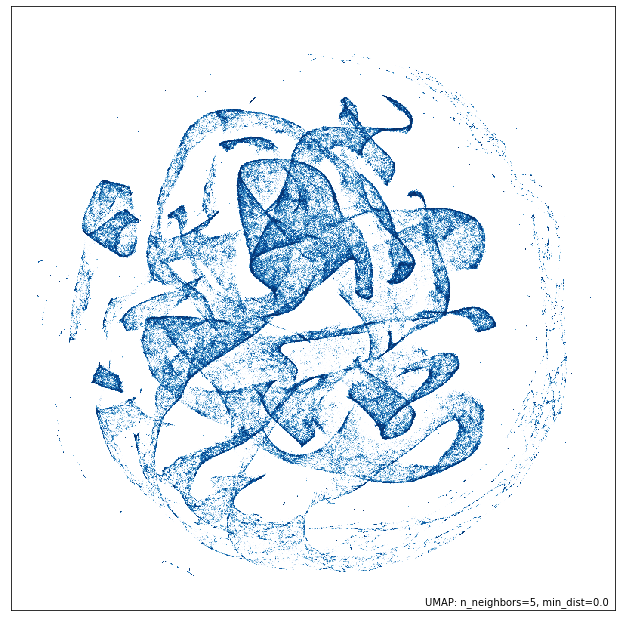

In [0]:
umap.plot.points(umap_results)

In [0]:
umap_results = umap.UMAP(n_neighbors=15, min_dist=0.0).fit(data_df.drop('fraud', axis=1))

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


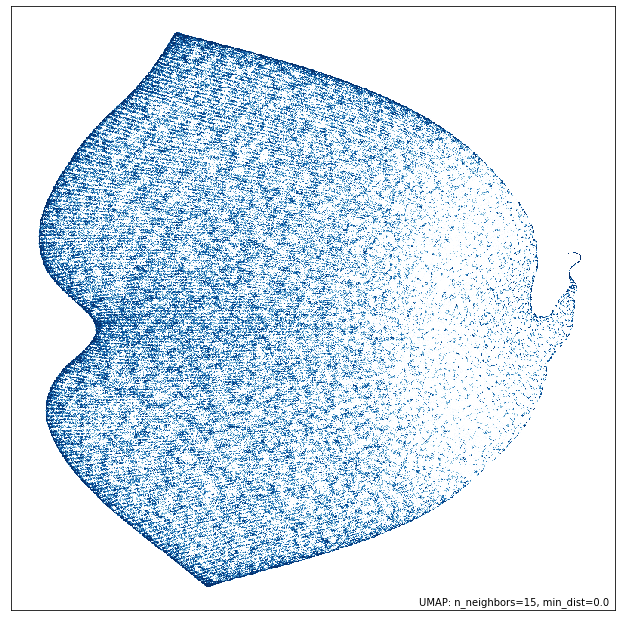

In [0]:
umap.plot.points(umap_results)

# Unsupervised Learning K-means clustering

Since I have structured data, I removed the target feature fraud and used KMeans clustering with my four separate datasets dealing with class imbalance.

In [211]:
#SMOTEEEN Smote oversampling at 10%
preds = KMeans(n_clusters=2, random_state=150).fit_predict(X_train_smoteenn_da)
print(metrics.adjusted_rand_score(y_train_smoteenn_da, preds))

0.08109372133254832


In [212]:
#SMOTETomek Smote oversampling at 10%
preds = KMeans(n_clusters=2, random_state=150).fit_predict(X_train_smotetomek_da)
metrics.adjusted_rand_score(y_train_smotetomek_da, preds)

0.0814840296600409

In [213]:
#SMOTEEN Smote oversampling balanced
preds = KMeans(n_clusters=2, random_state=150).fit_predict(X_train_smoteenn2_da)
metrics.adjusted_rand_score(y_train_smoteenn2_da, preds)

0.0022027160662060723

In [214]:
#SMOTE oversampling at 10% with random undersampling at 50%
preds = KMeans(n_clusters=2, random_state=150).fit_predict(X_train_sm_random_da)
metrics.adjusted_rand_score(y_train_sm_random_da, preds)

0.03446827814055324

# Supervised Learning

Using DASK distributed computing along with DASK GridSearchCV (dcv.GridSearchCV) to do hyperparameter tuning to see best hyperparameters, based on 5 fold cross validation.

## Decision tree with original unbalanced training dataset for base reference

In [98]:
#Unbalanced training dataset

hyper_para = {'criterion': ['entropy', 'gini'], 'max_features': range(5, 25, 1), 'max_depth': range(2, 20, 1), 'random_state': [100]}

#use DASK GridSearchCV for hyperparameter tuning
dec_base = dcv.GridSearchCV(tree.DecisionTreeClassifier(), hyper_para, scoring='recall_macro', refit='recall_macro', return_train_score=True,
                            cv=5)
dec_base.fit(X_train, y_train)

GridSearchCV(cache_cv=True, cv=5, error_score='raise',
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid=True, n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
          

In [99]:
dec_base.best_score_, dec_base.best_params_

(0.8807512925532915,
 {'criterion': 'entropy',
  'max_depth': 19,
  'max_features': 22,
  'random_state': 100})

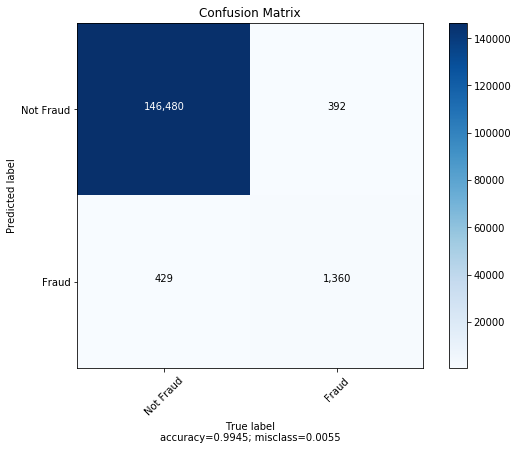

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    146872
       Fraud       0.78      0.76      0.77      1789

    accuracy                           0.99    148661
   macro avg       0.89      0.88      0.88    148661
weighted avg       0.99      0.99      0.99    148661



In [101]:
#fit best model hyperparameters and plot confusion matrix, along with classification report

dec_base2 = tree.DecisionTreeClassifier(**dec_base.best_params_)
dec_base2.fit(X_train, y_train)
preds = dec_base2.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['Not Fraud', 'Fraud'], title='Confusion Matrix', normalize=False)
print(classification_report(y_test, preds, target_names=['Not Fraud', 'Fraud']))

## SMOTEEEN Smote oversampling at 10%, ENN undersampling

In [30]:
hyper_para = {'criterion': ['entropy', 'gini'], 'max_features': range(5, 25, 1), 'max_depth': range(2, 20, 1), 'random_state': [100]}

dec_tree1 = dcv.GridSearchCV(tree.DecisionTreeClassifier(), hyper_para, scoring='recall_macro', refit='recall_macro', return_train_score=True,
                            cv=5)
dec_tree1.fit(X_train_smoteenn_da, y_train_smoteenn_da)

GridSearchCV(cache_cv=True, cv=5, error_score='raise',
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid=True, n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
          

In [31]:
dec_tree1.best_score_, dec_tree1.best_params_

(0.9840569804105509,
 {'criterion': 'entropy',
  'max_depth': 9,
  'max_features': 21,
  'random_state': 100})

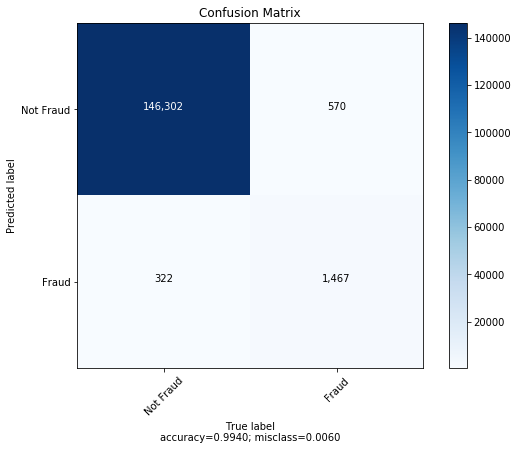

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    146872
       Fraud       0.72      0.82      0.77      1789

    accuracy                           0.99    148661
   macro avg       0.86      0.91      0.88    148661
weighted avg       0.99      0.99      0.99    148661



In [32]:
with joblib.parallel_backend('dask'):
    dec_tree2 = tree.DecisionTreeClassifier(**dec_tree1.best_params_)
    dec_tree2.fit(X_train_smoteenn_da, y_train_smoteenn_da)
    preds = dec_tree2.predict(X_test)
    confusion = confusion_matrix(y_test, preds)
    plot_confusion_matrix(cm=confusion, target_names=['Not Fraud', 'Fraud'], title='Confusion Matrix', normalize=False)

print(classification_report(y_test, preds, target_names=['Not Fraud', 'Fraud']))

## SMOTETomek Smote oversampling at 10%, Tomek undersampling

In [33]:
hyper_para = {'criterion': ['entropy', 'gini'], 'max_features': range(5, 25, 1), 'max_depth': range(2, 20, 1), 'random_state': [100]}

dec_tree3 = dcv.GridSearchCV(tree.DecisionTreeClassifier(), hyper_para, scoring='recall_macro', refit='recall_macro', return_train_score=True,
                            cv=5)
dec_tree3.fit(X_train_smotetomek_da, y_train_smotetomek_da)

GridSearchCV(cache_cv=True, cv=5, error_score='raise',
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid=True, n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
          

In [34]:
dec_tree3.best_score_, dec_tree3.best_params_

(0.9752958547577608,
 {'criterion': 'entropy',
  'max_depth': 7,
  'max_features': 24,
  'random_state': 100})

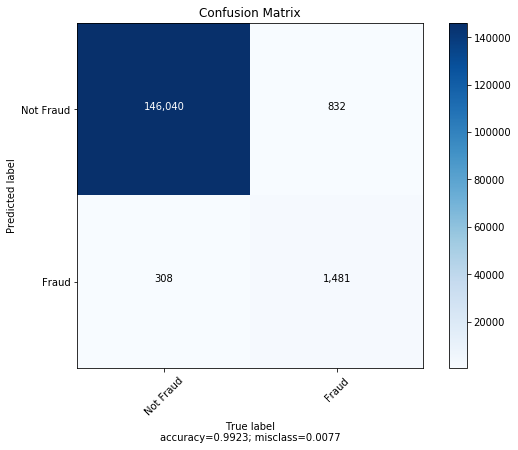

              precision    recall  f1-score   support

   Not Fraud       1.00      0.99      1.00    146872
       Fraud       0.64      0.83      0.72      1789

    accuracy                           0.99    148661
   macro avg       0.82      0.91      0.86    148661
weighted avg       0.99      0.99      0.99    148661



In [35]:
with joblib.parallel_backend('dask'):
    dec_tree4 = tree.DecisionTreeClassifier(**dec_tree3.best_params_)
    dec_tree4.fit(X_train_smotetomek_da, y_train_smotetomek_da)
    preds = dec_tree4.predict(X_test)
    confusion = confusion_matrix(y_test, preds)
    plot_confusion_matrix(cm=confusion, target_names=['Not Fraud', 'Fraud'], title='Confusion Matrix', normalize=False)

print(classification_report(y_test, preds, target_names=['Not Fraud', 'Fraud']))

## SMOTEENN Smote oversampling and ENN both balanced at 50%

In [40]:
hyper_para = {'criterion': ['entropy', 'gini'], 'max_features': range(5, 25, 1), 'max_depth': range(2, 20, 1), 'random_state': [100]}

dec_tree5 = dcv.GridSearchCV(tree.DecisionTreeClassifier(), hyper_para, scoring='recall_macro', refit='recall_macro', return_train_score=True,
                            cv=5)
dec_tree5.fit(X_train_smoteenn2_da, y_train_smoteenn2_da)

distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {"('decisiontreeclassifier-fit-score-8393540302d4da816e8deef6a377703c', 27, 1)": ('tcp://100.118.35.87:56880',)}
distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {"('decisiontreeclassifier-fit-score-8393540302d4da816e8deef6a377703c', 51, 4)": ('tcp://100.118.35.87:56878',)}


GridSearchCV(cache_cv=True, cv=5, error_score='raise',
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid=True, n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
          

In [41]:
dec_tree5.best_score_, dec_tree5.best_params_

(0.9964601938124698,
 {'criterion': 'entropy',
  'max_depth': 15,
  'max_features': 15,
  'random_state': 100})

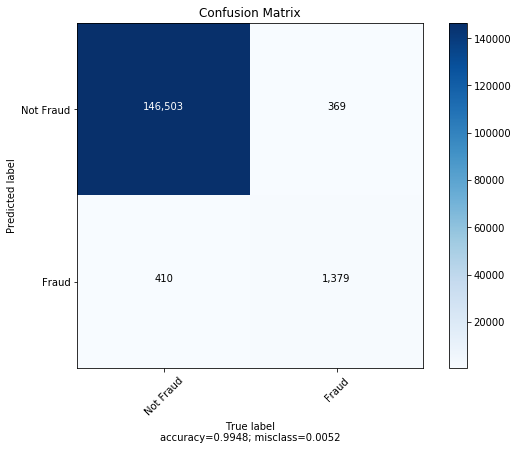

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    146872
       Fraud       0.79      0.77      0.78      1789

    accuracy                           0.99    148661
   macro avg       0.89      0.88      0.89    148661
weighted avg       0.99      0.99      0.99    148661



In [42]:
with joblib.parallel_backend('dask'):
    dec_tree6 = tree.DecisionTreeClassifier(**dec_tree5.best_params_)
    dec_tree6.fit(X_train_smoteenn2_da, y_train_smoteenn2_da)
    preds = dec_tree6.predict(X_test)
    confusion = confusion_matrix(y_test, preds)
    plot_confusion_matrix(cm=confusion, target_names=['Not Fraud', 'Fraud'], title='Confusion Matrix', normalize=False)

print(classification_report(y_test, preds, target_names=['Not Fraud', 'Fraud']))

## SMOTE oversampling 10%, random undersample 50%

In [36]:
hyper_para = {'criterion': ['entropy', 'gini'], 'max_features': range(5, 25, 1), 'max_depth': range(2, 20, 1), 'random_state': [100]}

dec_tree7 = dcv.GridSearchCV(tree.DecisionTreeClassifier(), hyper_para, scoring='recall_macro', refit='recall_macro', return_train_score=True,
                            cv=5)
dec_tree7.fit(X_train_sm_random_da, y_train_sm_random_da)

GridSearchCV(cache_cv=True, cv=5, error_score='raise',
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid=True, n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
          

In [37]:
dec_tree7.best_score_, dec_tree7.best_params_

(0.9851274804096058,
 {'criterion': 'entropy',
  'max_depth': 8,
  'max_features': 23,
  'random_state': 100})

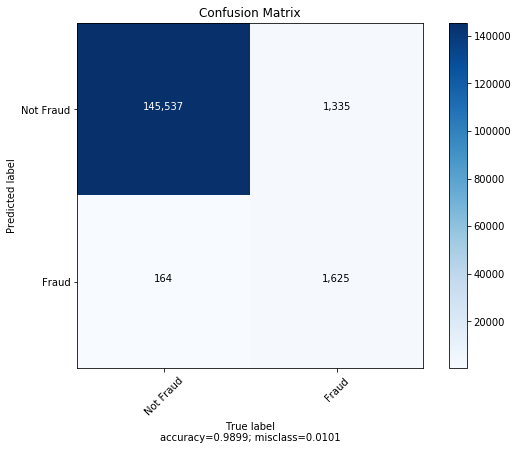

              precision    recall  f1-score   support

   Not Fraud       1.00      0.99      0.99    146872
       Fraud       0.55      0.91      0.68      1789

    accuracy                           0.99    148661
   macro avg       0.77      0.95      0.84    148661
weighted avg       0.99      0.99      0.99    148661



In [43]:
with joblib.parallel_backend('dask'):
    dec_tree8 = tree.DecisionTreeClassifier(**dec_tree7.best_params_)
    dec_tree8.fit(X_train_sm_random_da, y_train_sm_random_da)
    preds = dec_tree8.predict(X_test)
    confusion = confusion_matrix(y_test, preds)
    plot_confusion_matrix(cm=confusion, target_names=['Not Fraud', 'Fraud'], title='Confusion Matrix', normalize=False)

print(classification_report(y_test, preds, target_names=['Not Fraud', 'Fraud']))

# Logistic Regression original unbalanced training dataset reference model

In [102]:
hyper_para = [{'penalty': ['l2'], 'solver': ['liblinear'], 'max_iter': range(100, 500, 100), 'C': [0.01, 0.1, 1, 10, 100, 1000], 'random_state': [50]}, 
              {'penalty': ['l1'], 'solver': ['liblinear'], 'max_iter': range(100, 500, 100), 'C': [0.01, 0.1, 1, 10, 100, 1000], 'random_state': [50]}]

lr_base = dcv.GridSearchCV(LogisticRegression(), hyper_para, scoring='recall_macro', return_train_score=True, refit='recall_macro', cv=5)
lr_base.fit(X_train, y_train)

GridSearchCV(cache_cv=True, cv=5, error_score='raise',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid=True, n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100, 1000],
                          'max_iter': range(100, 500, 100), 'penalty': ['l2'],
                          'random_state': [50], 'solver': ['liblinear']},
                         {'C': [0.01, 0.1, 1, 10, 100, 1000],
                          'max_iter': range(100, 500, 100), 'penal

In [103]:
lr_base.best_score_, lr_base.best_params_

(0.8483948630993006,
 {'C': 10,
  'max_iter': 100,
  'penalty': 'l1',
  'random_state': 50,
  'solver': 'liblinear'})

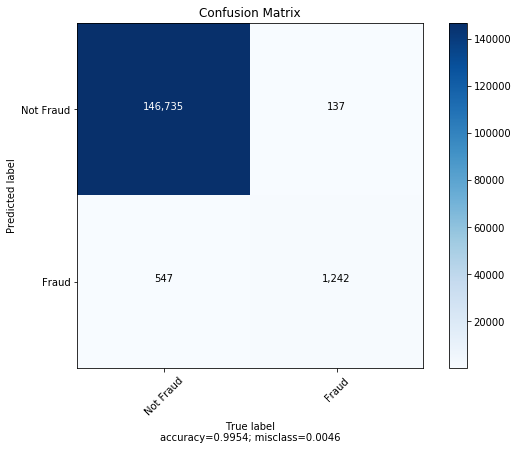

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    146872
       Fraud       0.90      0.69      0.78      1789

    accuracy                           1.00    148661
   macro avg       0.95      0.85      0.89    148661
weighted avg       1.00      1.00      1.00    148661



In [104]:
lr_base2 = LogisticRegression(**lr_base.best_params_)
lr_base2.fit(X_train, y_train)
preds = lr_base2.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['Not Fraud', 'Fraud'], title='Confusion Matrix', normalize=False)
print(classification_report(y_test, preds, target_names=['Not Fraud', 'Fraud']))

## SMOTEENN smote oversampling 10%, ENN undersampling

In [106]:
hyper_para = [{'penalty': ['l2'], 'solver': ['liblinear'], 'max_iter': range(100, 500, 100), 'C': [0.01, 0.1, 1, 10, 100, 1000], 'random_state': [50]}, 
              {'penalty': ['l1'], 'solver': ['liblinear'], 'max_iter': range(100, 500, 100), 'C': [0.01, 0.1, 1, 10, 100, 1000], 'random_state': [50]}]

lr = dcv.GridSearchCV(LogisticRegression(), hyper_para, scoring='recall_macro', return_train_score=True, refit='recall_macro', cv=5)
lr.fit(X_train_smoteenn_da, y_train_smoteenn_da)

GridSearchCV(cache_cv=True, cv=5, error_score='raise',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid=True, n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100, 1000],
                          'max_iter': range(100, 500, 100), 'penalty': ['l2'],
                          'random_state': [50], 'solver': ['liblinear']},
                         {'C': [0.01, 0.1, 1, 10, 100, 1000],
                          'max_iter': range(100, 500, 100), 'penal

In [107]:
lr.best_score_, lr.best_params_

(0.9562097337520961,
 {'C': 1000,
  'max_iter': 100,
  'penalty': 'l1',
  'random_state': 50,
  'solver': 'liblinear'})

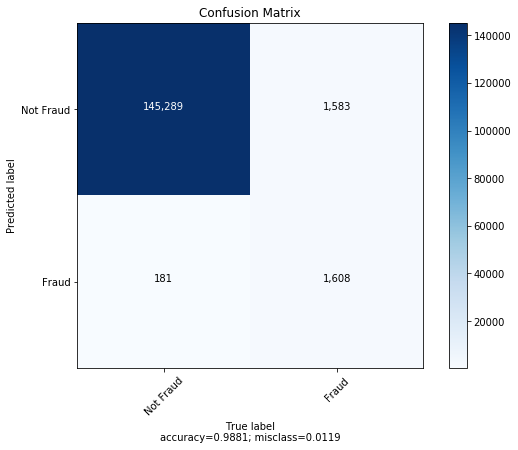

              precision    recall  f1-score   support

   Not Fraud       1.00      0.99      0.99    146872
       Fraud       0.50      0.90      0.65      1789

    accuracy                           0.99    148661
   macro avg       0.75      0.94      0.82    148661
weighted avg       0.99      0.99      0.99    148661



In [108]:
lr2 = LogisticRegression(**lr.best_params_)
lr2.fit(X_train_smoteenn_da, y_train_smoteenn_da)
preds = lr2.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['Not Fraud', 'Fraud'], title='Confusion Matrix', normalize=False)
print(classification_report(y_test, preds, target_names=['Not Fraud', 'Fraud']))

## SMOTETomek oversampling 10%, Tomek undersampling

In [110]:
hyper_para = [{'penalty': ['l2'], 'solver': ['liblinear'], 'max_iter': range(100, 500, 100), 'C': [0.01, 0.1, 1, 10, 100, 1000], 'random_state': [50]}, 
              {'penalty': ['l1'], 'solver': ['liblinear'], 'max_iter': range(100, 500, 100), 'C': [0.01, 0.1, 1, 10, 100, 1000], 'random_state': [50]}]

lr3 = dcv.GridSearchCV(LogisticRegression(), hyper_para, scoring='recall_macro', return_train_score=True, refit='recall_macro', cv=5)
lr3.fit(X_train_smotetomek_da, y_train_smotetomek_da)

GridSearchCV(cache_cv=True, cv=5, error_score='raise',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid=True, n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100, 1000],
                          'max_iter': range(100, 500, 100), 'penalty': ['l2'],
                          'random_state': [50], 'solver': ['liblinear']},
                         {'C': [0.01, 0.1, 1, 10, 100, 1000],
                          'max_iter': range(100, 500, 100), 'penal

In [111]:
lr3.best_score_, lr3.best_params_

(0.9385939347355161,
 {'C': 1000,
  'max_iter': 100,
  'penalty': 'l1',
  'random_state': 50,
  'solver': 'liblinear'})

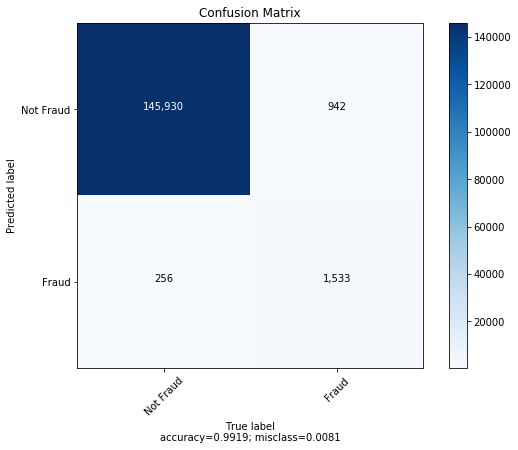

              precision    recall  f1-score   support

   Not Fraud       1.00      0.99      1.00    146872
       Fraud       0.62      0.86      0.72      1789

    accuracy                           0.99    148661
   macro avg       0.81      0.93      0.86    148661
weighted avg       0.99      0.99      0.99    148661



In [112]:
lr4 = LogisticRegression(**lr3.best_params_)
lr4.fit(X_train_smotetomek_da, y_train_smotetomek_da)
preds = lr4.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['Not Fraud', 'Fraud'], title='Confusion Matrix', normalize=False)
print(classification_report(y_test, preds, target_names=['Not Fraud', 'Fraud']))

## SMOTE 10% oversample, random undersample

In [113]:
hyper_para = [{'penalty': ['l2'], 'solver': ['liblinear'], 'max_iter': range(100, 500, 100), 'C': [0.01, 0.1, 1, 10, 100, 1000], 'random_state': [50]}, 
              {'penalty': ['l1'], 'solver': ['liblinear'], 'max_iter': range(100, 500, 100), 'C': [0.01, 0.1, 1, 10, 100, 1000], 'random_state': [50]}]

lr5 = dcv.GridSearchCV(LogisticRegression(), hyper_para, scoring='recall_macro', return_train_score=True, refit='recall_macro', cv=5)
lr5.fit(X_train_sm_random_da, y_train_sm_random_da)

GridSearchCV(cache_cv=True, cv=5, error_score='raise',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid=True, n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100, 1000],
                          'max_iter': range(100, 500, 100), 'penalty': ['l2'],
                          'random_state': [50], 'solver': ['liblinear']},
                         {'C': [0.01, 0.1, 1, 10, 100, 1000],
                          'max_iter': range(100, 500, 100), 'penal

In [114]:
lr5.best_score_, lr5.best_params_

(0.9749699720800649,
 {'C': 1,
  'max_iter': 100,
  'penalty': 'l1',
  'random_state': 50,
  'solver': 'liblinear'})

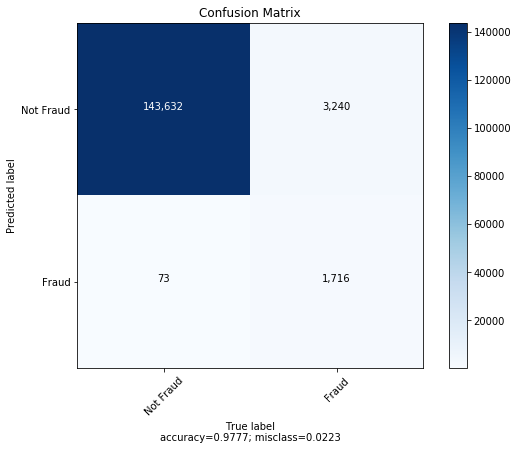

              precision    recall  f1-score   support

   Not Fraud       1.00      0.98      0.99    146872
       Fraud       0.35      0.96      0.51      1789

    accuracy                           0.98    148661
   macro avg       0.67      0.97      0.75    148661
weighted avg       0.99      0.98      0.98    148661



In [115]:
lr6 = LogisticRegression(**lr5.best_params_)
lr6.fit(X_train_sm_random_da, y_train_sm_random_da)
preds = lr6.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['Not Fraud', 'Fraud'], title='Confusion Matrix', normalize=False)
print(classification_report(y_test, preds, target_names=['Not Fraud', 'Fraud']))

# KNN Classification original unbalanced training dataset

In [95]:
hyper_para = {'leaf_size': range(10, 30, 5), 'n_neighbors': range(10, 20, 1), 'p': [1, 2]}

knn_base = dcv.GridSearchCV(KNeighborsClassifier(), hyper_para, scoring='recall_macro', return_train_score=True, refit='recall_macro', cv=5)
knn_base.fit(X_train, y_train)

GridSearchCV(cache_cv=True, cv=5, error_score='raise',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid=True, n_jobs=-1,
             param_grid={'leaf_size': range(10, 30, 5),
                         'n_neighbors': range(10, 20), 'p': [1, 2]},
             refit='recall_macro', return_train_score=True, scheduler=None,
             scoring='recall_macro')

In [96]:
knn_base.best_score_, knn_base.best_params_

(0.7882956688887937, {'leaf_size': 10, 'n_neighbors': 11, 'p': 1})

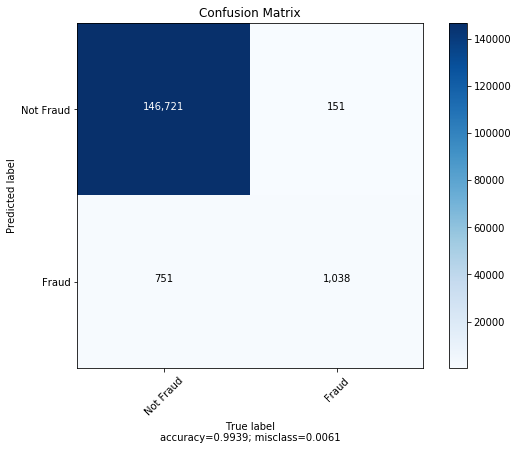

              precision    recall  f1-score   support

   Not Fraud       0.99      1.00      1.00    146872
       Fraud       0.87      0.58      0.70      1789

    accuracy                           0.99    148661
   macro avg       0.93      0.79      0.85    148661
weighted avg       0.99      0.99      0.99    148661



In [97]:
knn_base2 = KNeighborsClassifier(**knn_base.best_params_)
knn_base2.fit(X_train, y_train)
preds = knn_base2.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['Not Fraud', 'Fraud'], title='Confusion Matrix', normalize=False)

print(classification_report(y_test, preds, target_names=['Not Fraud', 'Fraud']))

## SMOTEENN SMOTE 10%, ENN undersampling

In [71]:
hyper_para = {'leaf_size': range(10, 30, 5), 'n_neighbors': range(10, 20, 1), 'p': [1, 2]}

knn = dcv.GridSearchCV(KNeighborsClassifier(), hyper_para, scoring='recall_macro', return_train_score=True, refit='recall_macro', cv=5)
knn.fit(X_train_smoteenn_da, y_train_smoteenn_da)

GridSearchCV(cache_cv=True, cv=5, error_score='raise',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid=True, n_jobs=-1,
             param_grid={'leaf_size': range(10, 30, 5),
                         'n_neighbors': range(10, 20), 'p': [1, 2]},
             refit='recall_macro', return_train_score=True, scheduler=None,
             scoring='recall_macro')

In [72]:
knn.best_score_, knn.best_params_

(0.9892987011727308, {'leaf_size': 10, 'n_neighbors': 11, 'p': 1})

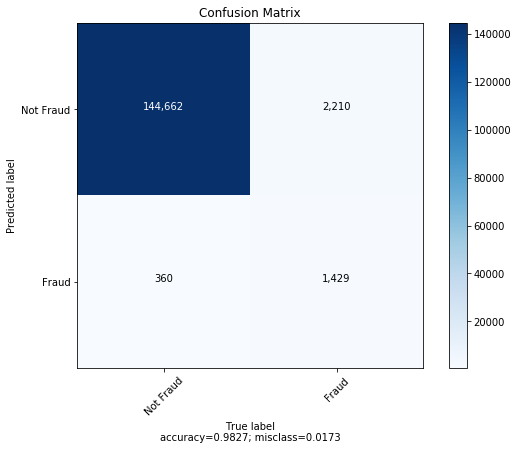

              precision    recall  f1-score   support

   Not Fraud       1.00      0.98      0.99    146872
       Fraud       0.39      0.80      0.53      1789

    accuracy                           0.98    148661
   macro avg       0.70      0.89      0.76    148661
weighted avg       0.99      0.98      0.99    148661



In [74]:
knn2 = KNeighborsClassifier(**knn.best_params_)
knn2.fit(X_train_smoteenn_da, y_train_smoteenn_da)
preds = knn2.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['Not Fraud', 'Fraud'], title='Confusion Matrix', normalize=False)

print(classification_report(y_test, preds, target_names=['Not Fraud', 'Fraud']))

In [76]:
#SMOTEENN SMOTE 10%, ENN undersampling

hyper_para = {'leaf_size': range(5, 15, 2), 'n_neighbors': range(10, 15, 1), 'p': [1, 2]}

knn3 = dcv.GridSearchCV(KNeighborsClassifier(), hyper_para, scoring='recall_macro', return_train_score=True, refit='recall_macro', cv=5)
knn3.fit(X_train_smoteenn_da, y_train_smoteenn_da)

GridSearchCV(cache_cv=True, cv=5, error_score='raise',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid=True, n_jobs=-1,
             param_grid={'leaf_size': range(5, 15, 2),
                         'n_neighbors': range(10, 15), 'p': [1, 2]},
             refit='recall_macro', return_train_score=True, scheduler=None,
             scoring='recall_macro')

In [78]:
knn3.best_score_, knn3.best_params_

(0.9892987011727308, {'leaf_size': 5, 'n_neighbors': 11, 'p': 1})

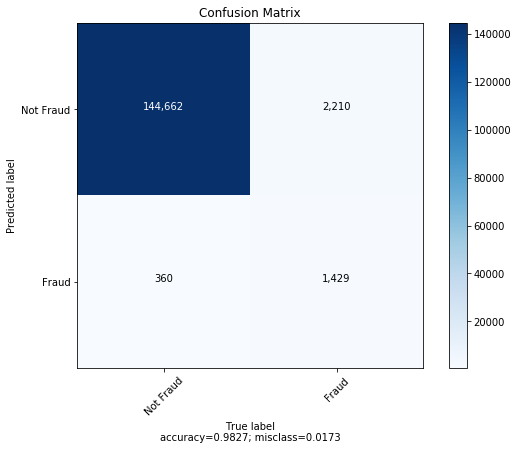

              precision    recall  f1-score   support

   Not Fraud       1.00      0.98      0.99    146872
       Fraud       0.39      0.80      0.53      1789

    accuracy                           0.98    148661
   macro avg       0.70      0.89      0.76    148661
weighted avg       0.99      0.98      0.99    148661



In [79]:
knn4 = KNeighborsClassifier(**knn3.best_params_)
knn4.fit(X_train_smoteenn_da, y_train_smoteenn_da)
preds = knn4.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['Not Fraud', 'Fraud'], title='Confusion Matrix', normalize=False)

print(classification_report(y_test, preds, target_names=['Not Fraud', 'Fraud']))

## SMOTETOMEK SMOTE 10%, TOMEK undersampling

In [80]:
hyper_para = {'leaf_size': range(5, 10, 2), 'n_neighbors': range(10, 15, 1), 'p': [1]}

knn5 = dcv.GridSearchCV(KNeighborsClassifier(), hyper_para, scoring='recall_macro', return_train_score=True, refit='recall_macro', cv=5)
knn5.fit(X_train_smotetomek_da, y_train_smotetomek_da)

GridSearchCV(cache_cv=True, cv=5, error_score='raise',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid=True, n_jobs=-1,
             param_grid={'leaf_size': range(5, 10, 2),
                         'n_neighbors': range(10, 15), 'p': [1]},
             refit='recall_macro', return_train_score=True, scheduler=None,
             scoring='recall_macro')

In [81]:
knn5.best_score_, knn5.best_params_

(0.98391460307648, {'leaf_size': 7, 'n_neighbors': 11, 'p': 1})

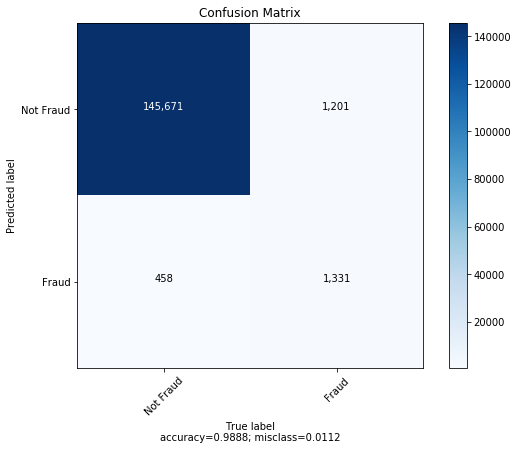

              precision    recall  f1-score   support

   Not Fraud       1.00      0.99      0.99    146872
       Fraud       0.53      0.74      0.62      1789

    accuracy                           0.99    148661
   macro avg       0.76      0.87      0.81    148661
weighted avg       0.99      0.99      0.99    148661



In [82]:
knn6 = KNeighborsClassifier(**knn5.best_params_)
knn6.fit(X_train_smotetomek_da, y_train_smotetomek_da)
preds = knn6.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['Not Fraud', 'Fraud'], title='Confusion Matrix', normalize=False)

print(classification_report(y_test, preds, target_names=['Not Fraud', 'Fraud']))

## SMOTEENN SMOTE oversampling and ENN undersampling 50% balanced

In [83]:
hyper_para = {'leaf_size': range(5, 10, 2), 'n_neighbors': range(10, 15, 1), 'p': [1]}

knn7 = dcv.GridSearchCV(KNeighborsClassifier(), hyper_para, scoring='recall_macro', return_train_score=True, refit='recall_macro', cv=5)
knn7.fit(X_train_smoteenn2_da, y_train_smoteenn2_da)

GridSearchCV(cache_cv=True, cv=5, error_score='raise',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid=True, n_jobs=-1,
             param_grid={'leaf_size': range(5, 10, 2),
                         'n_neighbors': range(10, 15), 'p': [1]},
             refit='recall_macro', return_train_score=True, scheduler=None,
             scoring='recall_macro')

In [84]:
knn7.best_score_, knn7.best_params_

(0.9915110164562829, {'leaf_size': 5, 'n_neighbors': 10, 'p': 1})

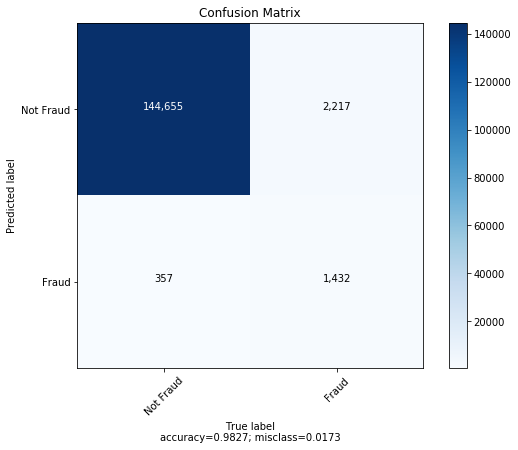

              precision    recall  f1-score   support

   Not Fraud       1.00      0.98      0.99    146872
       Fraud       0.39      0.80      0.53      1789

    accuracy                           0.98    148661
   macro avg       0.69      0.89      0.76    148661
weighted avg       0.99      0.98      0.99    148661



In [85]:
knn8 = KNeighborsClassifier(**knn7.best_params_)
knn8.fit(X_train_smoteenn2_da, y_train_smoteenn2_da)
preds = knn8.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['Not Fraud', 'Fraud'], title='Confusion Matrix', normalize=False)

print(classification_report(y_test, preds, target_names=['Not Fraud', 'Fraud']))

## SMOTE 10% oversampling, 50% random undersampling

In [86]:
hyper_para = {'leaf_size': range(5, 10, 2), 'n_neighbors': range(10, 15, 1), 'p': [1]}

knn9 = dcv.GridSearchCV(KNeighborsClassifier(), hyper_para, scoring='recall_macro', return_train_score=True, refit='recall_macro', cv=5)
knn9.fit(X_train_sm_random_da, y_train_sm_random_da)

GridSearchCV(cache_cv=True, cv=5, error_score='raise',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid=True, n_jobs=-1,
             param_grid={'leaf_size': range(5, 10, 2),
                         'n_neighbors': range(10, 15), 'p': [1]},
             refit='recall_macro', return_train_score=True, scheduler=None,
             scoring='recall_macro')

In [87]:
knn9.best_score_, knn9.best_params_

(0.9822843337697195, {'leaf_size': 7, 'n_neighbors': 10, 'p': 1})

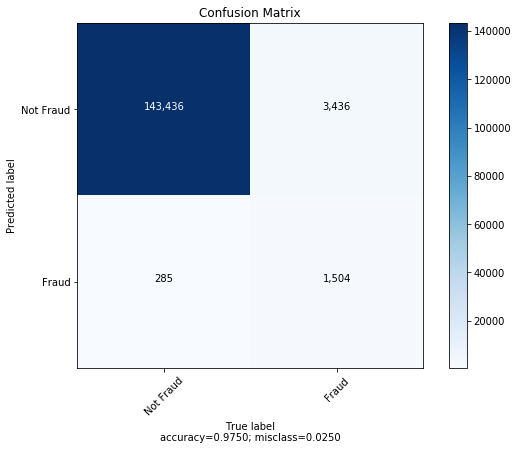

              precision    recall  f1-score   support

   Not Fraud       1.00      0.98      0.99    146872
       Fraud       0.30      0.84      0.45      1789

    accuracy                           0.97    148661
   macro avg       0.65      0.91      0.72    148661
weighted avg       0.99      0.97      0.98    148661



In [88]:
knn10 = KNeighborsClassifier(**knn9.best_params_)
knn10.fit(X_train_sm_random_da, y_train_sm_random_da)
preds = knn10.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['Not Fraud', 'Fraud'], title='Confusion Matrix', normalize=False)

print(classification_report(y_test, preds, target_names=['Not Fraud', 'Fraud']))

# RandomForest classifier with original unbalanced training dataset

In [116]:
hyper_para = {'criterion': ['gini'], 'max_features': range(10, 15, 1), 'max_depth': range(19, 25, 2), 'random_state': [100], 'n_estimators': [500]}

forest_base = dcv.GridSearchCV(ensemble.RandomForestClassifier(), hyper_para, scoring='recall_macro', return_train_score=True, refit='recall_macro', cv=5)
forest_base.fit(X_train, y_train)

GridSearchCV(cache_cv=True, cv=5, error_score='raise',
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                

In [117]:
forest_base.best_score_, forest_base.best_params_

(0.8881023641803169,
 {'criterion': 'gini',
  'max_depth': 23,
  'max_features': 10,
  'n_estimators': 500,
  'random_state': 100})

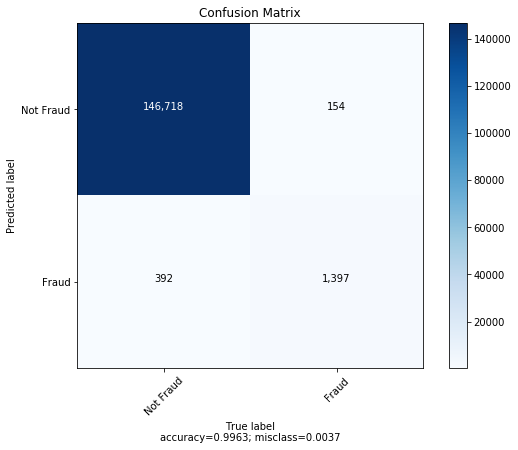

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    146872
       Fraud       0.90      0.78      0.84      1789

    accuracy                           1.00    148661
   macro avg       0.95      0.89      0.92    148661
weighted avg       1.00      1.00      1.00    148661



In [118]:
forest_base2 = ensemble.RandomForestClassifier(**forest_base.best_params_)
forest_base2.fit(X_train, y_train)
preds = forest_base2.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['Not Fraud', 'Fraud'], title='Confusion Matrix', normalize=False)

print(classification_report(y_test, preds, target_names=['Not Fraud', 'Fraud']))

## SMOTEENN SMOTE oversampling 10%, ENN undersampling

In [43]:
hyper_para = {'criterion': ['gini'], 'max_features': range(10, 15, 1), 'max_depth': range(15, 25, 2), 'random_state': [100], 'n_estimators': [500]}

forest = dcv.GridSearchCV(ensemble.RandomForestClassifier(), hyper_para, scoring='recall_macro', return_train_score=True, refit='recall_macro', cv=5)
forest.fit(X_train_smoteenn_da, y_train_smoteenn_da)

GridSearchCV(cache_cv=True, cv=5, error_score='raise',
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                

In [44]:
forest.best_score_, forest.best_params_

(0.9839325281855446,
 {'criterion': 'gini',
  'max_depth': 23,
  'max_features': 14,
  'n_estimators': 500,
  'random_state': 100})

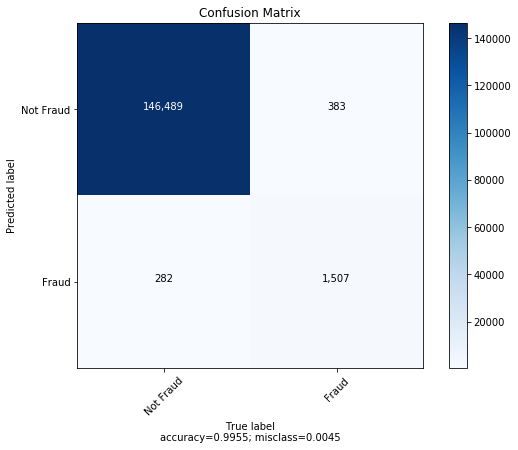

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    146872
       Fraud       0.80      0.84      0.82      1789

    accuracy                           1.00    148661
   macro avg       0.90      0.92      0.91    148661
weighted avg       1.00      1.00      1.00    148661



In [49]:
forest2 = ensemble.RandomForestClassifier(**forest.best_params_)
forest2.fit(X_train_smoteenn_da, y_train_smoteenn_da)
preds = forest2.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['Not Fraud', 'Fraud'], title='Confusion Matrix', normalize=False)

print(classification_report(y_test, preds, target_names=['Not Fraud', 'Fraud']))

In [50]:
#SMOTEENN SMOTE 10%, ENN
hyper_para = {'criterion': ['entropy', 'gini'], 'max_features': range(15, 20, 1), 'max_depth': range(25, 35, 2), 'random_state': [100], 'n_estimators': [500]}

forest3 = dcv.GridSearchCV(ensemble.RandomForestClassifier(), hyper_para, scoring='recall_macro', return_train_score=True, refit='recall_macro', cv=5)
forest3.fit(X_train_smoteenn_da, y_train_smoteenn_da)

GridSearchCV(cache_cv=True, cv=5, error_score='raise',
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                

In [51]:
forest3.best_score_, forest3.best_params_

(0.9839400780411861,
 {'criterion': 'gini',
  'max_depth': 27,
  'max_features': 19,
  'n_estimators': 500,
  'random_state': 100})

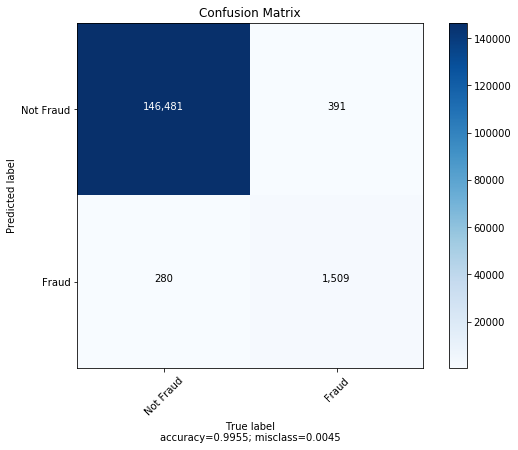

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    146872
       Fraud       0.79      0.84      0.82      1789

    accuracy                           1.00    148661
   macro avg       0.90      0.92      0.91    148661
weighted avg       1.00      1.00      1.00    148661



In [52]:
forest4 = ensemble.RandomForestClassifier(**forest3.best_params_)
forest4.fit(X_train_smoteenn_da, y_train_smoteenn_da)
preds = forest4.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['Not Fraud', 'Fraud'], title='Confusion Matrix', normalize=False)

print(classification_report(y_test, preds, target_names=['Not Fraud', 'Fraud']))

## SMOTETomek SMOTE oversampling 10%, TOMEK undersampling

In [57]:
hyper_para = {'criterion': ['entropy', 'gini'], 'max_features': range(20, 25, 1), 'max_depth': range(25, 35, 2), 'random_state': [100], 'n_estimators': [500]}

forest5 = dcv.GridSearchCV(ensemble.RandomForestClassifier(), hyper_para, scoring='recall_macro', return_train_score=True, refit='recall_macro', cv=5)
forest5.fit(X_train_smotetomek_da, y_train_smotetomek_da)

GridSearchCV(cache_cv=True, cv=5, error_score='raise',
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                

In [58]:
forest5.best_score_, forest5.best_params_

(0.9778753360119137,
 {'criterion': 'gini',
  'max_depth': 31,
  'max_features': 24,
  'n_estimators': 500,
  'random_state': 100})

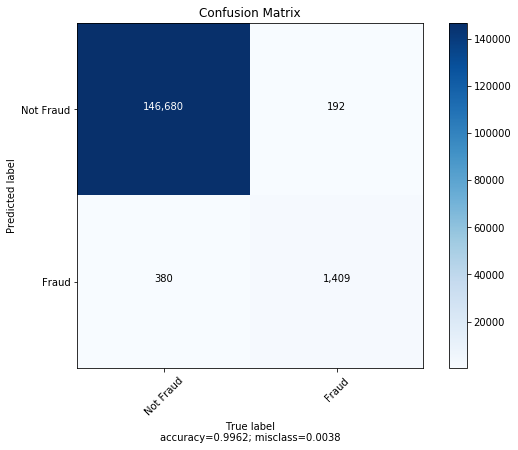

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    146872
       Fraud       0.88      0.79      0.83      1789

    accuracy                           1.00    148661
   macro avg       0.94      0.89      0.91    148661
weighted avg       1.00      1.00      1.00    148661



In [59]:
forest6 = ensemble.RandomForestClassifier(**forest5.best_params_)
forest6.fit(X_train_smotetomek_da, y_train_smotetomek_da)
preds = forest6.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['Not Fraud', 'Fraud'], title='Confusion Matrix', normalize=False)

print(classification_report(y_test, preds, target_names=['Not Fraud', 'Fraud']))

In [60]:
#SMOTETomek SMOTE 10%, TOMEK undersampling
hyper_para = {'criterion': ['gini'], 'max_features': range(10, 15, 1), 'max_depth': range(19, 25, 2), 'random_state': [100], 'n_estimators': [500]}

forest7 = dcv.GridSearchCV(ensemble.RandomForestClassifier(), hyper_para, scoring='recall_macro', return_train_score=True, refit='recall_macro', cv=5)
forest7.fit(X_train_smotetomek_da, y_train_smotetomek_da)

GridSearchCV(cache_cv=True, cv=5, error_score='raise',
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                

In [61]:
forest7.best_score_, forest7.best_params_

(0.9771398934329031,
 {'criterion': 'gini',
  'max_depth': 23,
  'max_features': 14,
  'n_estimators': 500,
  'random_state': 100})

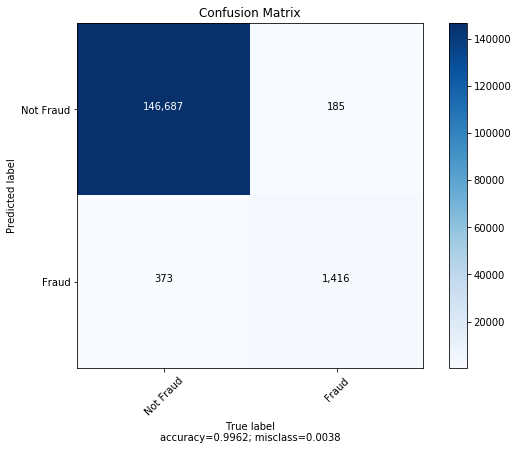

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    146872
       Fraud       0.88      0.79      0.84      1789

    accuracy                           1.00    148661
   macro avg       0.94      0.90      0.92    148661
weighted avg       1.00      1.00      1.00    148661



In [62]:
forest8 = ensemble.RandomForestClassifier(**forest7.best_params_)
forest8.fit(X_train_smotetomek_da, y_train_smotetomek_da)
preds = forest8.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['Not Fraud', 'Fraud'], title='Confusion Matrix', normalize=False)

print(classification_report(y_test, preds, target_names=['Not Fraud', 'Fraud']))

## SMOTEENN SMOTE and ENN balanced

In [64]:
hyper_para = {'criterion': ['gini'], 'max_features': range(10, 15, 1), 'max_depth': range(19, 25, 2), 'random_state': [100], 'n_estimators': [500]}

forest9 = dcv.GridSearchCV(ensemble.RandomForestClassifier(), hyper_para, scoring='recall_macro', return_train_score=True, refit='recall_macro', cv=5)
forest9.fit(X_train_smoteenn2_da, y_train_smoteenn2_da)

GridSearchCV(cache_cv=True, cv=5, error_score='raise',
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                

In [65]:
forest9.best_score_, forest9.best_params_

(0.9971343146218711,
 {'criterion': 'gini',
  'max_depth': 19,
  'max_features': 14,
  'n_estimators': 500,
  'random_state': 100})

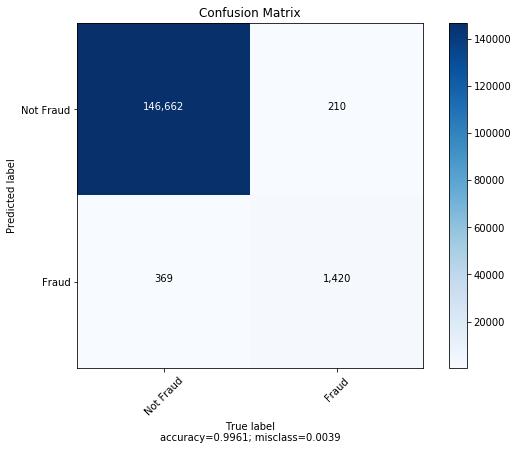

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    146872
       Fraud       0.87      0.79      0.83      1789

    accuracy                           1.00    148661
   macro avg       0.93      0.90      0.91    148661
weighted avg       1.00      1.00      1.00    148661



In [66]:
forest10 = ensemble.RandomForestClassifier(**forest9.best_params_)
forest10.fit(X_train_smoteenn2_da, y_train_smoteenn2_da)
preds = forest10.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['Not Fraud', 'Fraud'], title='Confusion Matrix', normalize=False)

print(classification_report(y_test, preds, target_names=['Not Fraud', 'Fraud']))

## SMOTE oversampling at 10%, random undersampling 50%

In [67]:
hyper_para = {'criterion': ['gini'], 'max_features': range(10, 15, 1), 'max_depth': range(19, 25, 2), 'random_state': [100], 'n_estimators': [500]}

forest11 = dcv.GridSearchCV(ensemble.RandomForestClassifier(), hyper_para, scoring='recall_macro', return_train_score=True, refit='recall_macro', cv=5)
forest11.fit(X_train_sm_random_da, y_train_sm_random_da)

GridSearchCV(cache_cv=True, cv=5, error_score='raise',
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                

In [68]:
forest11.best_score_, forest11.best_params_

(0.9839758263156987,
 {'criterion': 'gini',
  'max_depth': 21,
  'max_features': 14,
  'n_estimators': 500,
  'random_state': 100})

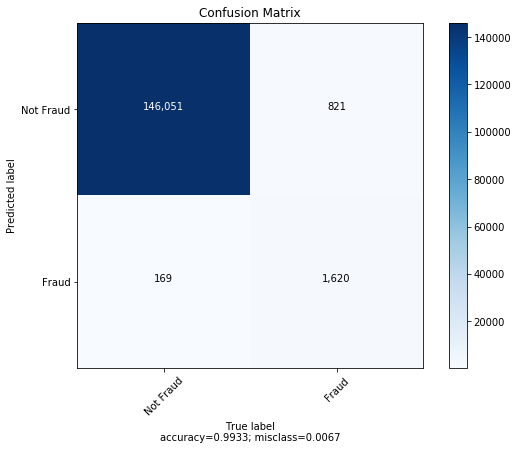

              precision    recall  f1-score   support

   Not Fraud       1.00      0.99      1.00    146872
       Fraud       0.66      0.91      0.77      1789

    accuracy                           0.99    148661
   macro avg       0.83      0.95      0.88    148661
weighted avg       0.99      0.99      0.99    148661



In [69]:
forest12 = ensemble.RandomForestClassifier(**forest11.best_params_)
forest12.fit(X_train_sm_random_da, y_train_sm_random_da)
preds = forest12.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['Not Fraud', 'Fraud'], title='Confusion Matrix', normalize=False)

print(classification_report(y_test, preds, target_names=['Not Fraud', 'Fraud']))

# Gradient Boosting original unbalanced training dataset

In [125]:
hyper_para = {'n_estimators': range(90, 200, 20), 'max_depth': range(4, 8, 2), 'random_state': [150], 'loss': ['deviance'], 'max_features': [15, 25, 2], 'subsample': [0.6, 0.7, 0.8, 0.9], 'learning_rate': np.arange(0.05, 0.2, 0.05)}

grad_base = dcv.GridSearchCV(ensemble.GradientBoostingClassifier(), hyper_para, scoring='recall_macro', return_train_score=True, refit='recall_macro', cv=5)
grad_base.fit(X_train, y_train)

GridSearchCV(cache_cv=True, cv=5, error_score='raise',
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimato...
                                                  validation_fracti

In [126]:
grad_base.best_score_, grad_base.best_params_

(0.8830523902378058,
 {'learning_rate': 0.1,
  'loss': 'deviance',
  'max_depth': 6,
  'max_features': 15,
  'n_estimators': 190,
  'random_state': 150,
  'subsample': 0.8})

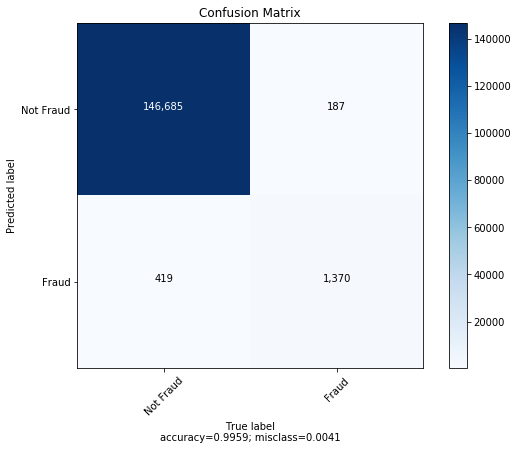

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    146872
       Fraud       0.88      0.77      0.82      1789

    accuracy                           1.00    148661
   macro avg       0.94      0.88      0.91    148661
weighted avg       1.00      1.00      1.00    148661



In [128]:
grad_base2 = ensemble.GradientBoostingClassifier(**grad_base.best_params_)
grad_base2.fit(X_train, y_train)
preds = grad_base2.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['Not Fraud', 'Fraud'], title='Confusion Matrix', normalize=False)

print(classification_report(y_test, preds, target_names=['Not Fraud', 'Fraud']))

In [129]:
#Base unbalanced training dataset

hyper_para = {'n_estimators': range(190, 300, 20), 'max_depth': range(4, 8, 2), 'random_state': [150], 'loss': ['deviance'], 'max_features': [5, 16, 2], 'subsample': [0.7, 0.8, 0.9], 'learning_rate': np.arange(0.05, 0.2, 0.05)}

grad_base3 = dcv.GridSearchCV(ensemble.GradientBoostingClassifier(), hyper_para, scoring='recall_macro', return_train_score=True, refit='recall_macro', cv=5)
grad_base3.fit(X_train, y_train)

GridSearchCV(cache_cv=True, cv=5, error_score='raise',
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimato...
                                                  validation_fracti

In [130]:
grad_base3.best_score_, grad_base3.best_params_

(0.8875164659140266,
 {'learning_rate': 0.1,
  'loss': 'deviance',
  'max_depth': 6,
  'max_features': 5,
  'n_estimators': 290,
  'random_state': 150,
  'subsample': 0.7})

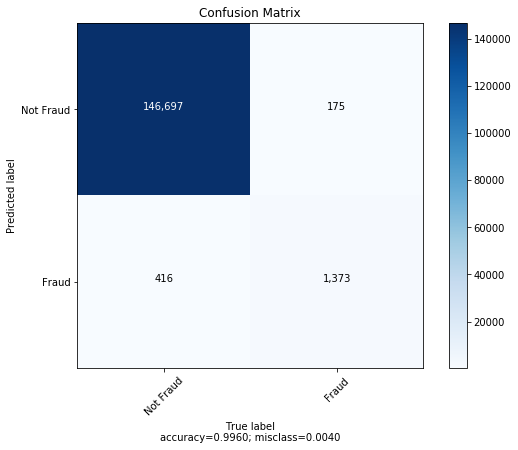

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    146872
       Fraud       0.89      0.77      0.82      1789

    accuracy                           1.00    148661
   macro avg       0.94      0.88      0.91    148661
weighted avg       1.00      1.00      1.00    148661



In [131]:
grad_base4 = ensemble.GradientBoostingClassifier(**grad_base3.best_params_)
grad_base4.fit(X_train, y_train)
preds = grad_base4.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['Not Fraud', 'Fraud'], title='Confusion Matrix', normalize=False)

print(classification_report(y_test, preds, target_names=['Not Fraud', 'Fraud']))

In [132]:
#Base unbalanced training dataset

hyper_para = {'n_estimators': range(300, 500, 50), 'max_depth': range(4, 8, 2), 'random_state': [150], 'loss': ['deviance'], 'max_features': [1, 6, 1], 'subsample': [0.6, 0.7, 0.8], 'learning_rate': np.arange(0.05, 0.2, 0.05)}

grad_base5 = dcv.GridSearchCV(ensemble.GradientBoostingClassifier(), hyper_para, scoring='recall_macro', return_train_score=True, refit='recall_macro', cv=5)
grad_base5.fit(X_train, y_train)

GridSearchCV(cache_cv=True, cv=5, error_score='raise',
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimato...
                                                  validation_fracti

In [133]:
grad_base5.best_score_, grad_base5.best_params_

(0.8878712228282691,
 {'learning_rate': 0.1,
  'loss': 'deviance',
  'max_depth': 6,
  'max_features': 6,
  'n_estimators': 350,
  'random_state': 150,
  'subsample': 0.7})

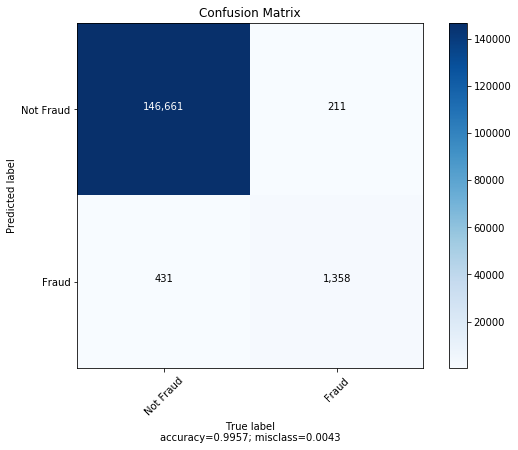

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    146872
       Fraud       0.87      0.76      0.81      1789

    accuracy                           1.00    148661
   macro avg       0.93      0.88      0.90    148661
weighted avg       1.00      1.00      1.00    148661



In [134]:
grad_base6 = ensemble.GradientBoostingClassifier(**grad_base5.best_params_)
grad_base6.fit(X_train, y_train)
preds = grad_base6.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['Not Fraud', 'Fraud'], title='Confusion Matrix', normalize=False)

print(classification_report(y_test, preds, target_names=['Not Fraud', 'Fraud']))

## SMOTEENN SMOTE 10% oversampling, ENN undersampling

In [135]:
hyper_para = {'n_estimators': [190], 'max_depth': range(4, 10, 2), 'random_state': [150], 'loss': ['deviance'], 'max_features': [5, 10, 1], 'subsample': [0.6, 0.7, 0.8], 'learning_rate': np.arange(0.05, 0.2, 0.05)}

grad = dcv.GridSearchCV(ensemble.GradientBoostingClassifier(), hyper_para, scoring='recall_macro', return_train_score=True, refit='recall_macro', cv=5)
grad.fit(X_train_smoteenn_da, y_train_smoteenn_da)

GridSearchCV(cache_cv=True, cv=5, error_score='raise',
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimato...
                                                  subsample=1.0, to

In [136]:
grad.best_score_, grad.best_params_

(0.9808781413666346,
 {'learning_rate': 0.05,
  'loss': 'deviance',
  'max_depth': 4,
  'max_features': 10,
  'n_estimators': 190,
  'random_state': 150,
  'subsample': 0.8})

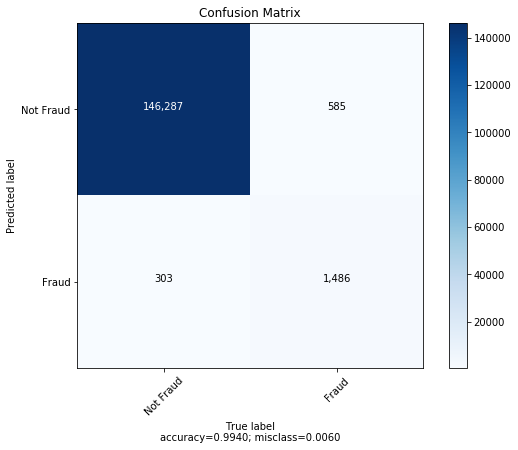

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    146872
       Fraud       0.72      0.83      0.77      1789

    accuracy                           0.99    148661
   macro avg       0.86      0.91      0.88    148661
weighted avg       0.99      0.99      0.99    148661



In [137]:
grad2 = ensemble.GradientBoostingClassifier(**grad.best_params_)
grad2.fit(X_train_smoteenn_da, y_train_smoteenn_da)
preds = grad2.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['Not Fraud', 'Fraud'], title='Confusion Matrix', normalize=False)

print(classification_report(y_test, preds, target_names=['Not Fraud', 'Fraud']))

## SMOTEENN SMOTE 10% oversampling, ENN undersampling

In [141]:
hyper_para = {'n_estimators': [190], 'max_depth': range(4, 10, 2), 'random_state': [150], 'loss': ['deviance'], 'max_features': [10, 20, 2], 'subsample': [0.7, 0.8, 0.9], 'learning_rate': np.arange(0.05, 0.2, 0.05)}

grad3 = dcv.GridSearchCV(ensemble.GradientBoostingClassifier(), hyper_para, scoring='recall_macro', return_train_score=True, refit='recall_macro', cv=5)
grad3.fit(X_train_smoteenn_da, y_train_smoteenn_da)

GridSearchCV(cache_cv=True, cv=5, error_score='raise',
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimato...
                                                  subsample=1.0, to

In [142]:
grad3.best_score_, grad3.best_params_

(0.9812159078703445,
 {'learning_rate': 0.05,
  'loss': 'deviance',
  'max_depth': 8,
  'max_features': 20,
  'n_estimators': 190,
  'random_state': 150,
  'subsample': 0.8})

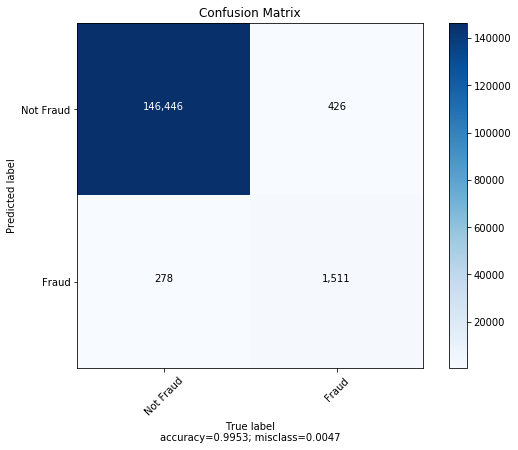

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    146872
       Fraud       0.78      0.84      0.81      1789

    accuracy                           1.00    148661
   macro avg       0.89      0.92      0.90    148661
weighted avg       1.00      1.00      1.00    148661



In [143]:
with joblib.parallel_backend('dask'):
    grad4 = ensemble.GradientBoostingClassifier(**grad3.best_params_)
    grad4.fit(X_train_smoteenn_da, y_train_smoteenn_da)
    preds = grad4.predict(X_test)

confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['Not Fraud', 'Fraud'], title='Confusion Matrix', normalize=False)

print(classification_report(y_test, preds, target_names=['Not Fraud', 'Fraud']))

In [55]:
#SMOTEENN SMOTE 10% oversampling, ENN undersampling

hyper_para = {'n_estimators': [190], 'max_depth': range(12, 17, 2), 'random_state': [150], 'loss': ['deviance'], 'max_features': [28, 32, 2], 'subsample': [0.8, 0.9], 'learning_rate': np.arange(0.15, 0.2, 0.05)}

grad5 = dcv.GridSearchCV(ensemble.GradientBoostingClassifier(), hyper_para, scoring='recall_macro', return_train_score=True, refit='recall_macro', cv=5)
grad5.fit(X_train_smoteenn_da, y_train_smoteenn_da)

GridSearchCV(cache_cv=True, cv=5, error_score='raise',
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimato...
                                                  subsample=1.0, to

In [56]:
grad5.best_score_, grad5.best_params_

(0.9834165379827554,
 {'learning_rate': 0.15,
  'loss': 'deviance',
  'max_depth': 14,
  'max_features': 32,
  'n_estimators': 190,
  'random_state': 150,
  'subsample': 0.8})

## SMOTEENN SMOTE 10% oversampling, ENN undersampling

Added in two additional parameters, n_iter_no_change =5 and tol = 0.01 to have each gradient boost model stop before full estimators are used. If training scores don't improve by 0.01 over the last 5 iterations, exit early.

In [58]:
grad6 = ensemble.GradientBoostingClassifier(**grad5.best_params_, n_iter_no_change = 5, tol = 0.01)

In [68]:
grad6.fit(X_train_smoteenn_da, y_train_smoteenn_da)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.15, loss='deviance', max_depth=14,
                           max_features=32, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=190,
                           n_iter_no_change=5, presort='deprecated',
                           random_state=150, subsample=0.8, tol=0.01,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [69]:
#show how many estimators were actually used out of the 190
grad6.n_estimators_

23

In [70]:
preds = grad6.predict(X_test)

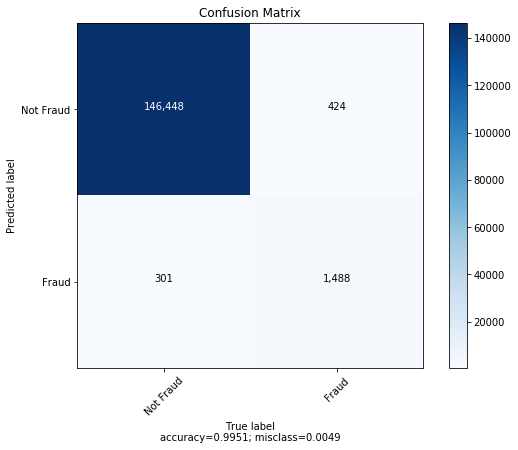

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    146872
       Fraud       0.78      0.83      0.80      1789

    accuracy                           1.00    148661
   macro avg       0.89      0.91      0.90    148661
weighted avg       1.00      1.00      1.00    148661



In [71]:
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['Not Fraud', 'Fraud'], title='Confusion Matrix', normalize=False)

print(classification_report(y_test, preds, target_names=['Not Fraud', 'Fraud']))

Compare the above model that exited early with only 23 estimators used versus the below model with the full 190 estimators used.  The model that exited early had a Fraud classification score of 0.78 precision and 0.83 recall versus the full model score of 0.77 precision and 0.84 precision.  By configuring the model to exit early, this allows model training to occur much faster, and also allows fitting to test data much faster.

In [72]:
grad62 = ensemble.GradientBoostingClassifier(**grad5.best_params_)
grad62.fit(X_train_smoteenn_da, y_train_smoteenn_da)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.15, loss='deviance', max_depth=14,
                           max_features=32, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=190,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=150, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

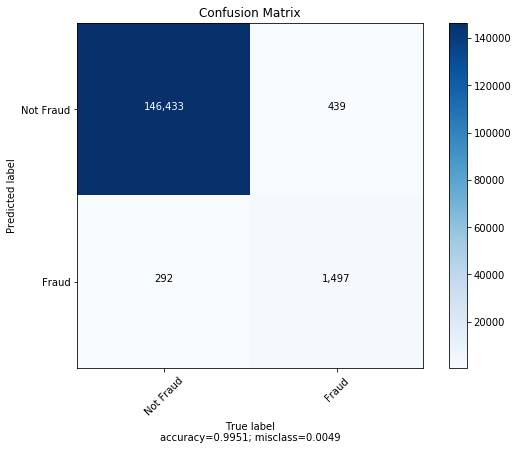

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    146872
       Fraud       0.77      0.84      0.80      1789

    accuracy                           1.00    148661
   macro avg       0.89      0.92      0.90    148661
weighted avg       1.00      1.00      1.00    148661



In [73]:
preds = grad62.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['Not Fraud', 'Fraud'], title='Confusion Matrix', normalize=False)

print(classification_report(y_test, preds, target_names=['Not Fraud', 'Fraud']))

## SMOTETOMEK SMOTE 10% oversampling, TOMEK undersampling

In [77]:
hyper_para = {'n_estimators': [100], 'max_depth': range(12, 17, 2), 'random_state': [150], 'loss': ['deviance'], 'max_features': [22, 31, 2], 'subsample': [0.7, 0.8, 0.9], 'learning_rate': np.arange(0.05, 0.15, 0.05)}

grad7 = dcv.GridSearchCV(ensemble.GradientBoostingClassifier(), hyper_para, scoring='recall_macro', return_train_score=True, refit='recall_macro', cv=5)
grad7.fit(X_train_smotetomek_da, y_train_smotetomek_da)

GridSearchCV(cache_cv=True, cv=5, error_score='raise',
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimato...
                                                  subsample=1.0, to

In [78]:
grad7.best_score_, grad7.best_params_

(0.9769106358394366,
 {'learning_rate': 0.05,
  'loss': 'deviance',
  'max_depth': 12,
  'max_features': 31,
  'n_estimators': 100,
  'random_state': 150,
  'subsample': 0.8})

In [79]:
#early stop if score improvement less than 0.01 over last 5 estimators
grad8 = ensemble.GradientBoostingClassifier(**grad7.best_params_, n_iter_no_change = 5, tol = 0.01)
grad8.fit(X_train_smotetomek_da, y_train_smotetomek_da)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=12,
                           max_features=31, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=5, presort='deprecated',
                           random_state=150, subsample=0.8, tol=0.01,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [80]:
grad8.n_estimators_

45

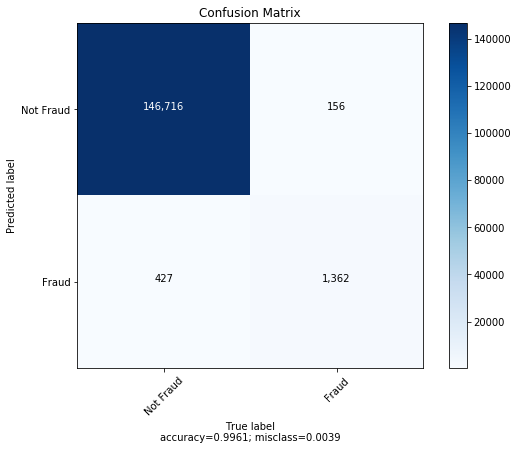

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    146872
       Fraud       0.90      0.76      0.82      1789

    accuracy                           1.00    148661
   macro avg       0.95      0.88      0.91    148661
weighted avg       1.00      1.00      1.00    148661



In [81]:
preds = grad8.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['Not Fraud', 'Fraud'], title='Confusion Matrix', normalize=False)

print(classification_report(y_test, preds, target_names=['Not Fraud', 'Fraud']))

## SMOTEENN balanced

I further adjusted model training by incorporating the model training early exit into the GridSearchCV hyperparameter tuning.  This allowed my hyperparameter tuning to run much faster since all instances no longer needed to run the full number of estimators.

In [82]:
hyper_para = {'n_estimators': [100], 'max_depth': range(10, 17, 2), 'random_state': [150], 'loss': ['deviance'], 
              'max_features': [22, 31, 2], 'subsample': [0.7, 0.8, 0.9], 'learning_rate': np.arange(0.05, 0.15, 0.05), 
             'n_iter_no_change': [5], 'tol': [0.01]}

grad9 = dcv.GridSearchCV(ensemble.GradientBoostingClassifier(), hyper_para, scoring='recall_macro', return_train_score=True, refit='recall_macro', cv=5)
grad9.fit(X_train_smoteenn2_da, y_train_smoteenn2_da)

GridSearchCV(cache_cv=True, cv=5, error_score='raise',
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimato...
                                                  verbose=0, warm_s

In [83]:
grad9.best_score_, grad9.best_params_

(0.9974112554003038,
 {'learning_rate': 0.05,
  'loss': 'deviance',
  'max_depth': 12,
  'max_features': 31,
  'n_estimators': 100,
  'n_iter_no_change': 5,
  'random_state': 150,
  'subsample': 0.7,
  'tol': 0.01})

In [84]:
#early stop if score improvement less than 0.01 over last 5 estimators
grad10 = ensemble.GradientBoostingClassifier(**grad9.best_params_)
grad10.fit(X_train_smotetomek_da, y_train_smotetomek_da)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=12,
                           max_features=31, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=5, presort='deprecated',
                           random_state=150, subsample=0.7, tol=0.01,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [85]:
grad10.n_estimators_

45

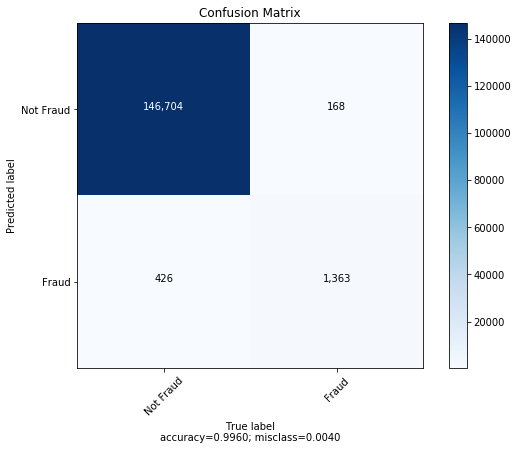

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    146872
       Fraud       0.89      0.76      0.82      1789

    accuracy                           1.00    148661
   macro avg       0.94      0.88      0.91    148661
weighted avg       1.00      1.00      1.00    148661



In [86]:
preds = grad10.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['Not Fraud', 'Fraud'], title='Confusion Matrix', normalize=False)

print(classification_report(y_test, preds, target_names=['Not Fraud', 'Fraud']))

## SMOTE oversampling at 10%, random undersampling 50%

In [87]:
hyper_para = {'n_estimators': [100], 'max_depth': range(10, 17, 2), 'random_state': [150], 'loss': ['deviance'], 
              'max_features': [22, 31, 2], 'subsample': [0.7, 0.8, 0.9], 'learning_rate': np.arange(0.05, 0.15, 0.05), 
             'n_iter_no_change': [5], 'tol': [0.01]}

grad11 = dcv.GridSearchCV(ensemble.GradientBoostingClassifier(), hyper_para, scoring='recall_macro', return_train_score=True, refit='recall_macro', cv=5)
grad11.fit(X_train_sm_random_da, y_train_sm_random_da)

GridSearchCV(cache_cv=True, cv=5, error_score='raise',
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimato...
                                                  verbose=0, warm_s

In [88]:
grad11.best_score_, grad11.best_params_

(0.9846113287524402,
 {'learning_rate': 0.05,
  'loss': 'deviance',
  'max_depth': 10,
  'max_features': 22,
  'n_estimators': 100,
  'n_iter_no_change': 5,
  'random_state': 150,
  'subsample': 0.7,
  'tol': 0.01})

In [89]:
#early stop if score improvement less than 0.01 over last 5 estimators
grad12 = ensemble.GradientBoostingClassifier(**grad11.best_params_)
grad12.fit(X_train_sm_random_da, y_train_sm_random_da)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=10,
                           max_features=22, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=5, presort='deprecated',
                           random_state=150, subsample=0.7, tol=0.01,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [90]:
grad12.n_estimators_

65

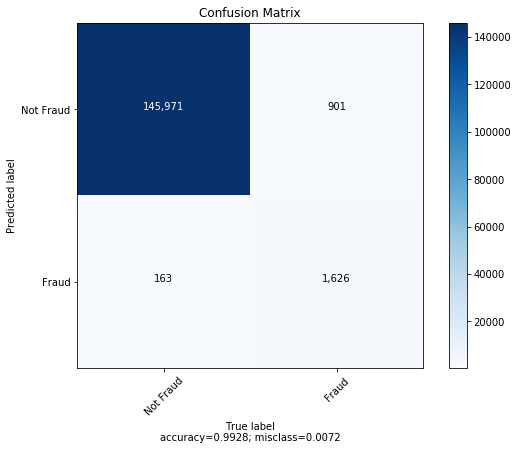

              precision    recall  f1-score   support

   Not Fraud       1.00      0.99      1.00    146872
       Fraud       0.64      0.91      0.75      1789

    accuracy                           0.99    148661
   macro avg       0.82      0.95      0.87    148661
weighted avg       0.99      0.99      0.99    148661



In [91]:
preds = grad12.predict(X_test)
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm=confusion, target_names=['Not Fraud', 'Fraud'], title='Confusion Matrix', normalize=False)

print(classification_report(y_test, preds, target_names=['Not Fraud', 'Fraud']))

# Best Models

Because we are dealing with preventing fraud transaction, I compared the two best performing models based on a combination of fraud recall and precision, with the heaviest weight on recall.  It's my opinion that we want to prevent as much fraud as possible, and for those transactions that are false positive for fraud, a simple email or text to the user to confirm the transaction as fraud or not and then have them run it again if it's not fraud is much more acceptable then false negative fraud predictions.  I took into consideration of precision as well because if different models were close enough in recall, about .05 to 0.1 but the better recall model had much poorer precision, I went with the model with the lower recall and higher precision.

Lastly, to settle on the final model, I took into consideration the time it took to train the model, as well as to predict fraud transactions.

## RandomForest

In [92]:
params = {'criterion': 'gini',
  'max_depth': 23,
  'max_features': 14,
  'n_estimators': 500,
  'random_state': 100}

forest_best = ensemble.RandomForestClassifier(**params)

In [93]:
%%time

forest_best.fit(X_train_smoteenn_da, y_train_smoteenn_da)

Wall time: 17min 13s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=23, max_features=14,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=100,
                       verbose=0, warm_start=False)

In [107]:
%%time

preds_forest = forest_best.predict(X_test)

Wall time: 13.3 s


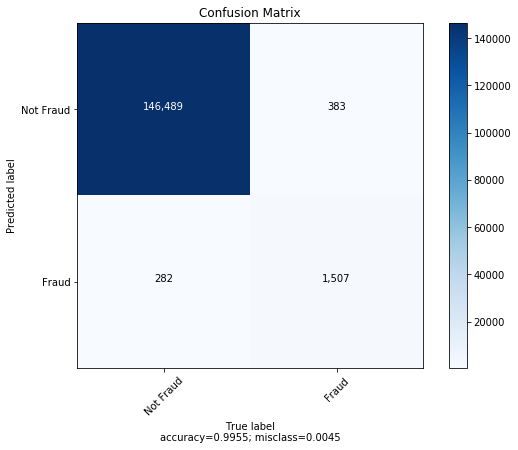

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    146872
       Fraud       0.77      0.83      0.80      1789

    accuracy                           1.00    148661
   macro avg       0.88      0.92      0.90    148661
weighted avg       1.00      1.00      1.00    148661



In [108]:
confusion = confusion_matrix(y_test, preds_forest)
plot_confusion_matrix(cm=confusion, target_names=['Not Fraud', 'Fraud'], title='Confusion Matrix', normalize=False)

print(classification_report(y_test, preds, target_names=['Not Fraud', 'Fraud']))

# Deep Learning

In [272]:
import tensorflow as tf


In [273]:
tf.config.list_physical_devices('GPU')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Lucky Vang\.conda\envs\deep-learning\lib\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-273-3f8719ff6c39>", line 1, in <module>
    tf.config.list_physical_devices('GPU')
AttributeError: module 'tensorflow' has no attribute 'config'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Lucky Vang\.conda\envs\deep-learning\lib\site-packages\IPython\core\interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'AttributeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Lucky Vang\.conda\envs\deep-learning\lib\site-packages\tensorflow_core\python\pywrap_tensorflow.py", line 58, in <module>
    from tenso

AttributeError: module 'tensorflow' has no attribute 'config'

## RandomForest Feature Importance

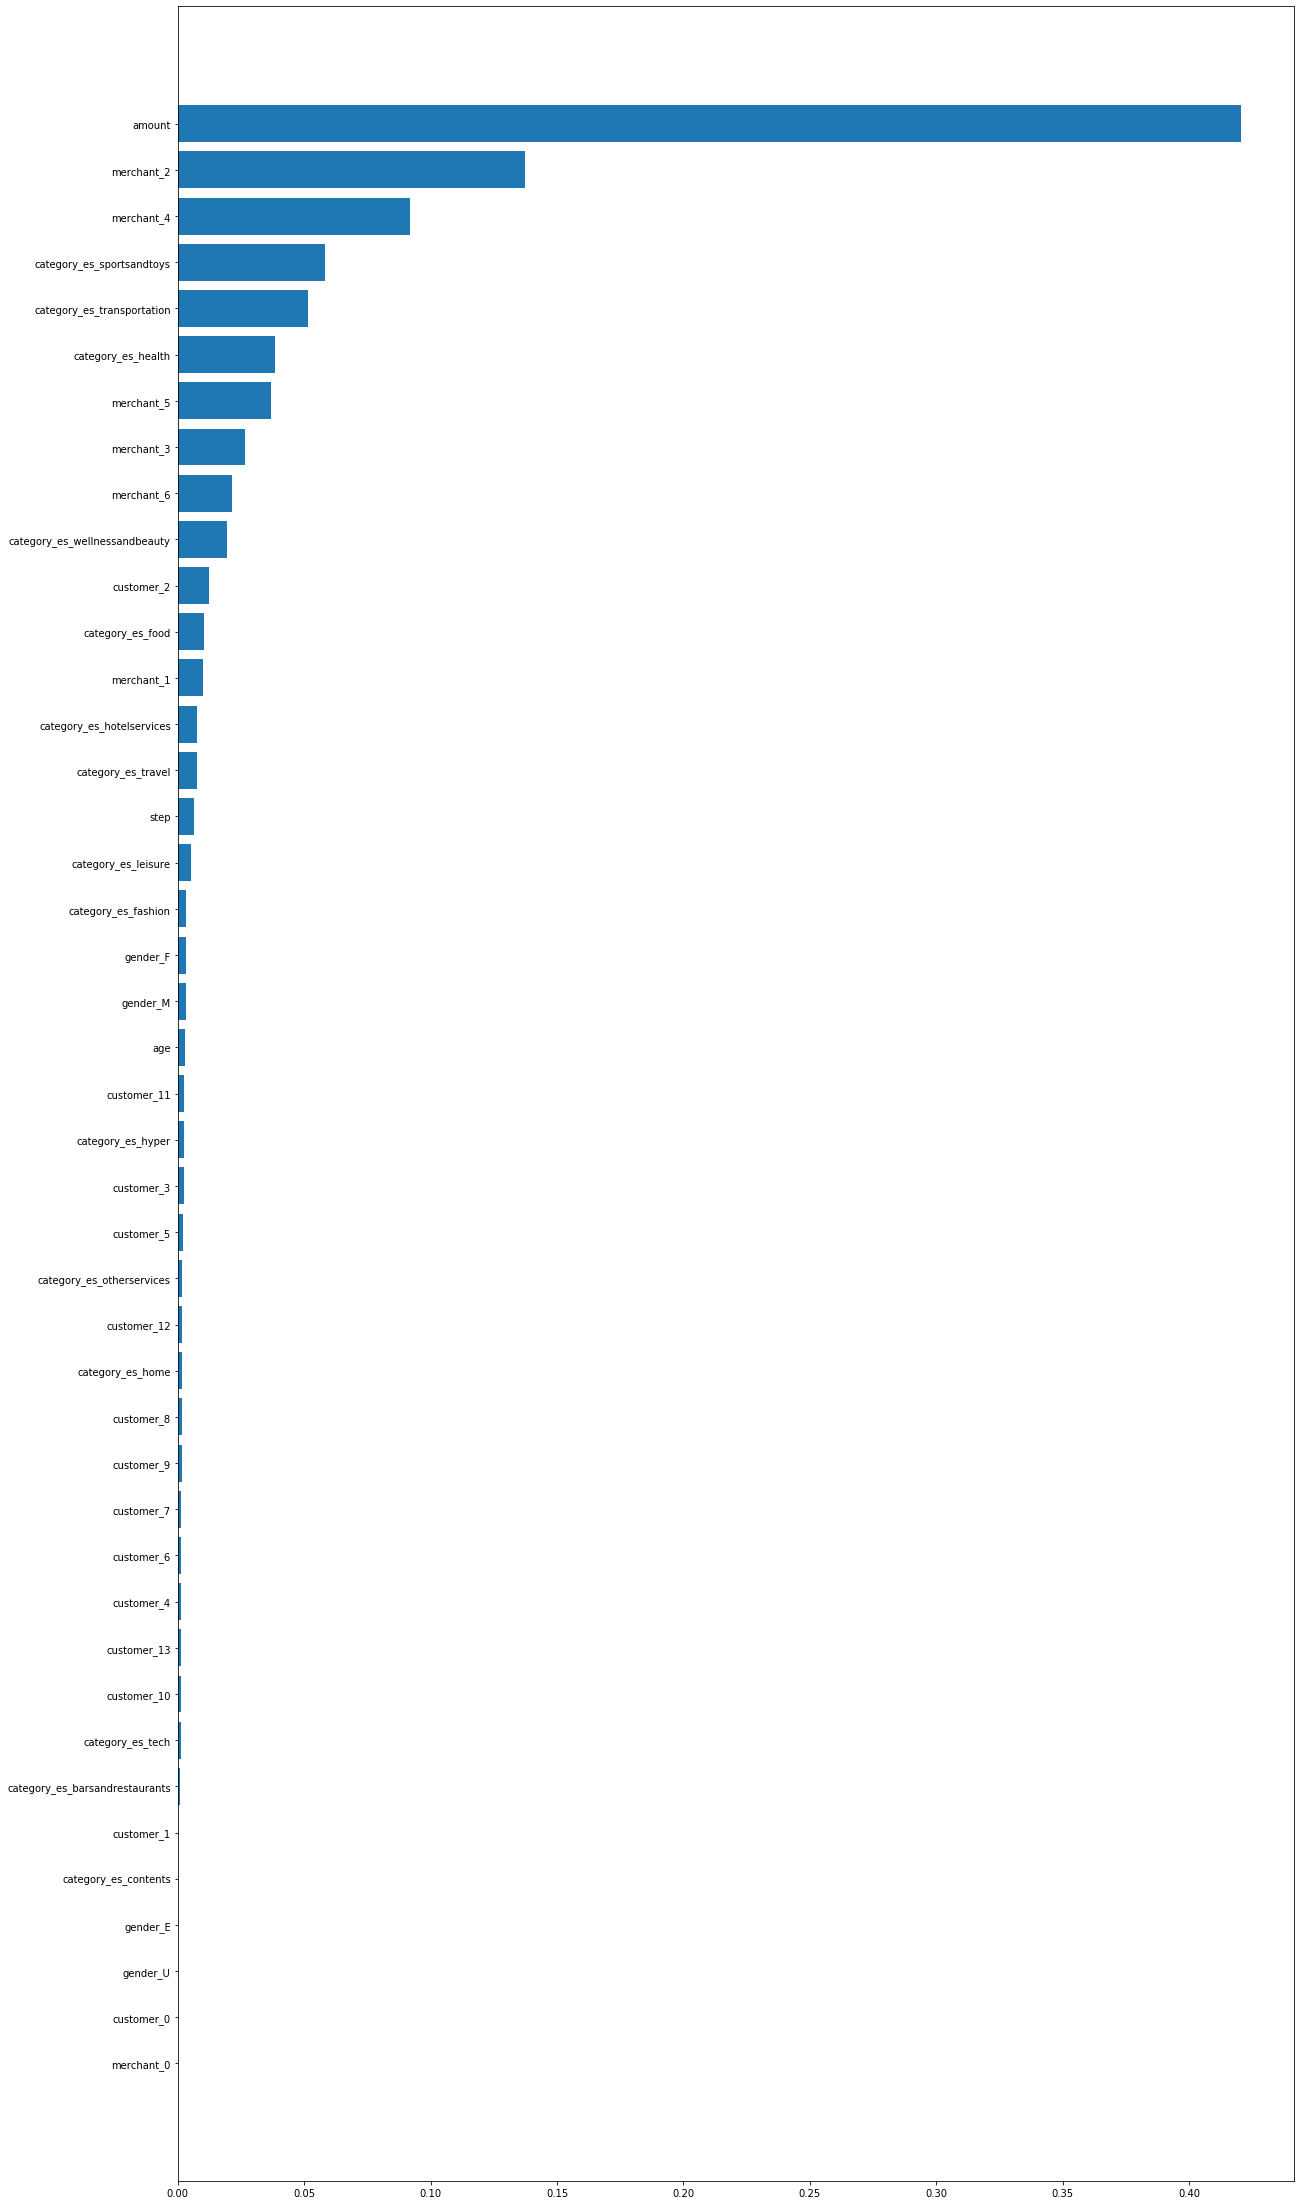

In [105]:
feat_imp = forest_best.feature_importances_

sorted_index = np.argsort(feat_imp)

x_range = range(len(feat_imp))
labels = np.array(X_train.keys())[sorted_index]
plt.figure(figsize=(20, 40))
plt.barh(x_range, feat_imp[sorted_index], align='center')
plt.yticks(x_range, X_train.keys()[sorted_index])
plt.show()

## Gradient Boost

In [96]:
params = {'learning_rate': 0.05,
  'loss': 'deviance',
  'max_depth': 8,
  'max_features': 20,
  'n_estimators': 190,
  'random_state': 150,
  'subsample': 0.8}

grad_best = ensemble.GradientBoostingClassifier(**params, n_iter_no_change = 5, tol = 0.01)

In [97]:
%%time

grad_best.fit(X_train_smoteenn_da, y_train_smoteenn_da)

Wall time: 1min 48s


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=8,
                           max_features=20, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=190,
                           n_iter_no_change=5, presort='deprecated',
                           random_state=150, subsample=0.8, tol=0.01,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [98]:
grad_best.n_estimators_

46

In [113]:
%%time

preds_grad = grad_best.predict(X_test)

Wall time: 488 ms


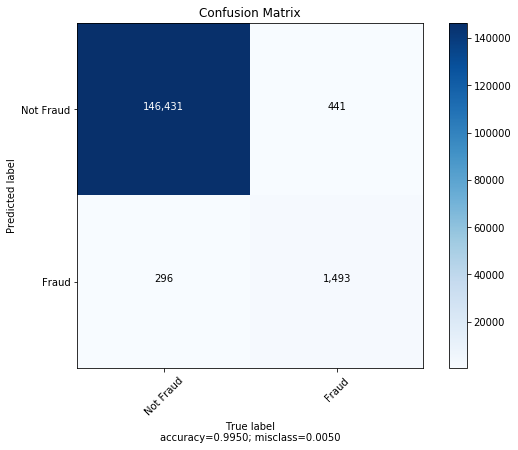

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    146872
       Fraud       0.77      0.83      0.80      1789

    accuracy                           1.00    148661
   macro avg       0.88      0.92      0.90    148661
weighted avg       1.00      1.00      1.00    148661



In [114]:
confusion = confusion_matrix(y_test, preds_grad)
plot_confusion_matrix(cm=confusion, target_names=['Not Fraud', 'Fraud'], title='Confusion Matrix', normalize=False)

print(classification_report(y_test, preds, target_names=['Not Fraud', 'Fraud']))

In [259]:
print(roc_auc_score(y_test, preds_grad))

0.915770911856081


## Gradient Boosting Feature Importance

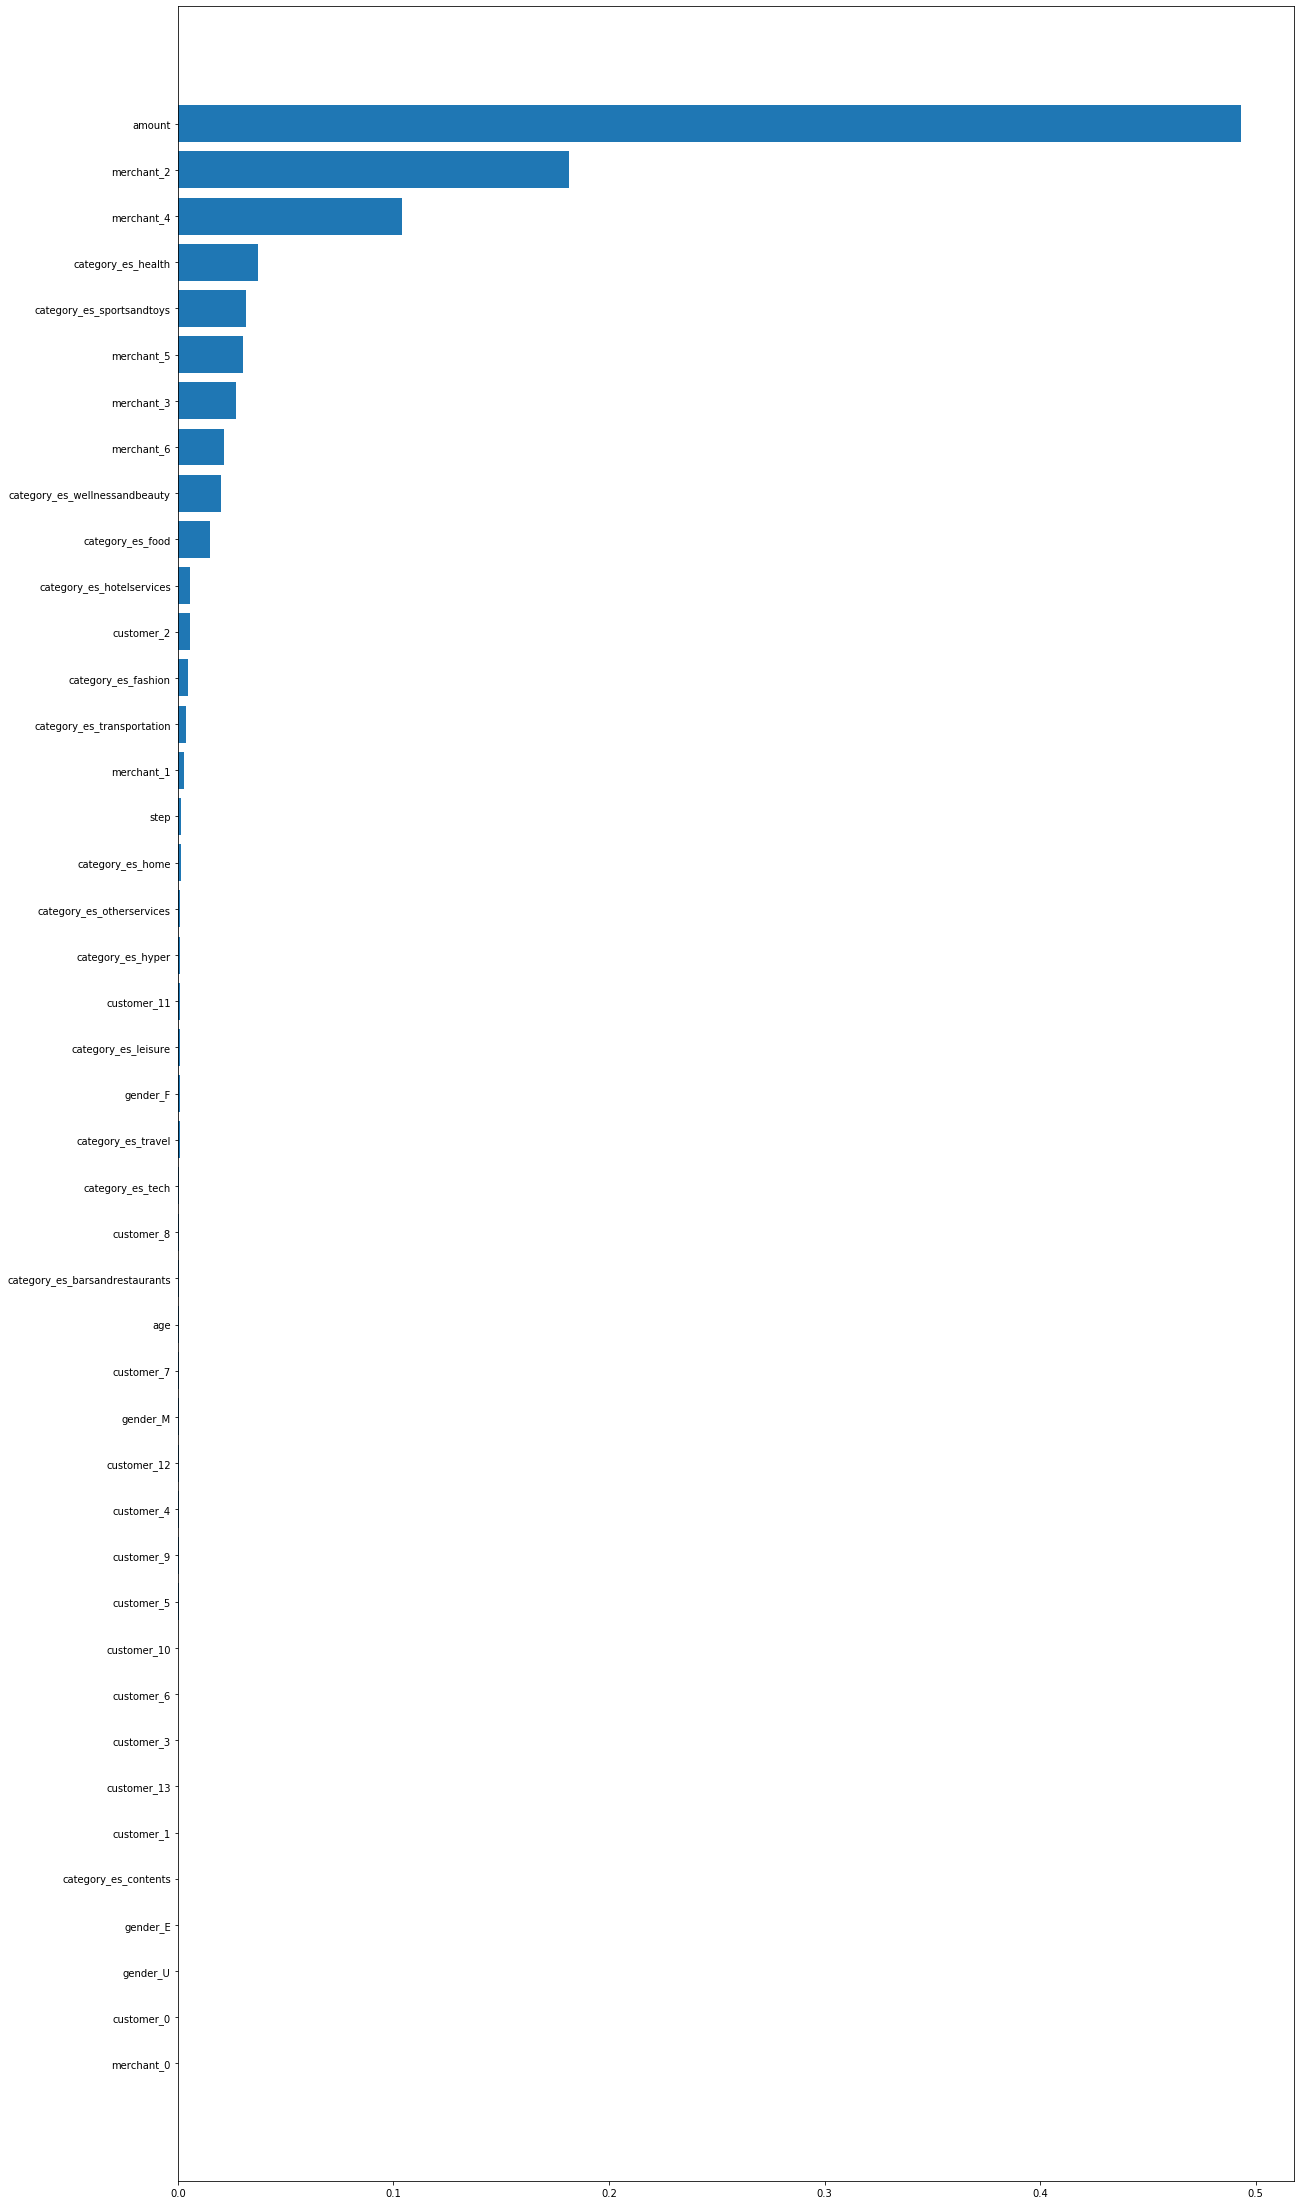

In [106]:
feat_imp = grad_best.feature_importances_

sorted_index = np.argsort(feat_imp)

x_range = range(len(feat_imp))
labels = np.array(X_train.keys())[sorted_index]
plt.figure(figsize=(20, 40))
plt.barh(x_range, feat_imp[sorted_index], align='center')
plt.yticks(x_range, X_train.keys()[sorted_index])
plt.show()

# Final Model Selection

I settled on using the gradient boosting model with SMOTEENN using SMOTE at 10% and ENN undersampling.  This model with the early stop was able to train in only about 1min 50secs, compared to the best random forest model training on the same dataset at 17min 13sec.  This also translated into test data fitting of only 488ms for the gradient boosting model compared to 1min 48 secs for the random forest model.  Both models also had the same recall and precision scores for the test dataset.

# Fraud Insights

As noted earlier as part of my EDA, amount was indeed a huge and the number one contributing factor into determining fraud transactions.

Below I go into some insights on how the gradient boosting model did for predicting fraud on the test dataset.  I compare the transaction amounts for various transactions as noted below.

In [111]:
#merge test feature dataset back with target feature dataset
test_merge = pd.concat([X_test, y_test], axis=1)

Next, I add in the predictions for each transaction from our gradient boost model into prediction feature column.  Then I create a new feature column error to compare the actual fraud type versus the predicted type.  Any row with a value of 0 was correctly classified, value 1 was false negative for fraud (missed fraud transaction), and value -1 was a false positive for fraud (incorrectly classified as fraud).

In [132]:
test_merge['prediction'] = preds_grad
test_merge['error'] = test_merge['fraud'] - test_merge['prediction']

test_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148661 entries, 515888 to 98959
Data columns (total 46 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   step                            148661 non-null  int64  
 1   customer_0                      148661 non-null  uint8  
 2   customer_1                      148661 non-null  uint8  
 3   customer_2                      148661 non-null  uint8  
 4   customer_3                      148661 non-null  uint8  
 5   customer_4                      148661 non-null  uint8  
 6   customer_5                      148661 non-null  uint8  
 7   customer_6                      148661 non-null  uint8  
 8   customer_7                      148661 non-null  uint8  
 9   customer_8                      148661 non-null  uint8  
 10  customer_9                      148661 non-null  uint8  
 11  customer_10                     148661 non-null  uint8  
 12  customer_11 

Let's take a look at some descriptive statistics about our classifications regarding the amount of the transaction.  As you can see below, our false negatives (error = 1) had a count of 296 with a mean amount of 74.877, minimum of 0.03, and max of 237.48.  The important thing here is that the false negatives did not contain any large fraudulent transactions and amounted to a total loss of 23,348.  This out of a total amount of all test data transactions of 5,607,213.10.

In [133]:
test_merge.groupby(['error'])['amount'].describe()

,count,mean,std,min,25%,50%,75%,max
error,,,,,,,,
-1,441.0,204.485873,188.637676,1.51,134.280,180.75,228.8400,1993.68
0,147924.0,37.146583,108.362174,0.00,13.680,26.80,42.3200,7432.48
1,296.0,74.877399,49.807423,0.03,36.395,66.19,109.6325,237.48


In [255]:
X_test['amount'].sum()

5607213.100000001

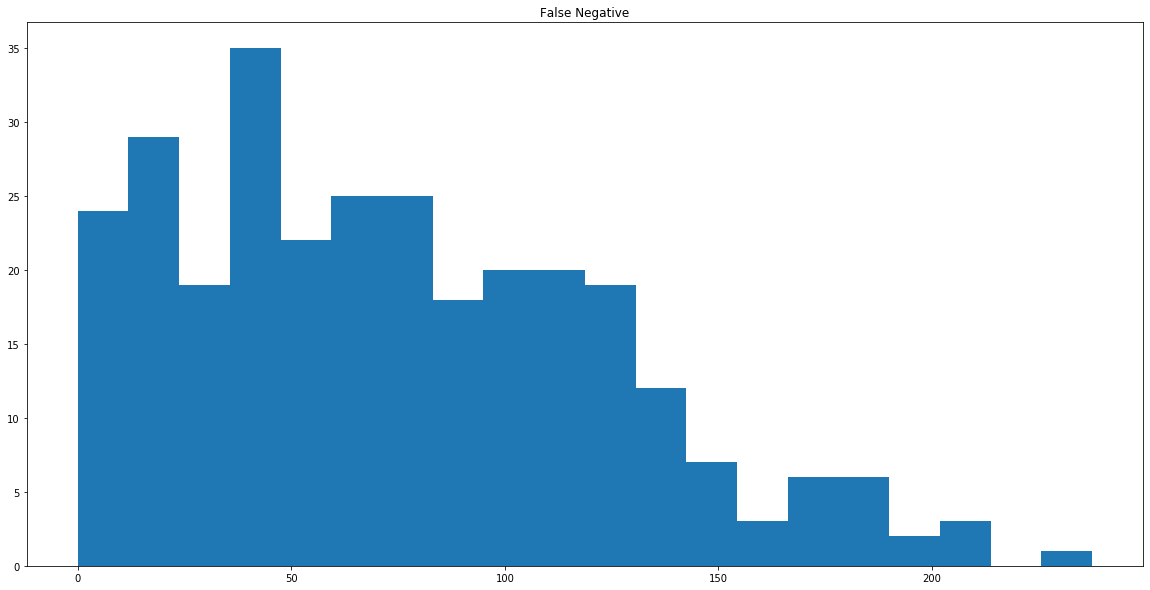

In [217]:
#Histogram of amount feature for false negative predictions
plt.figure(figsize=(20,10))
plt.hist(test_merge.loc[test_merge['error'] == 1]['amount'], bins = 20)
plt.title('False Negative')
plt.show()

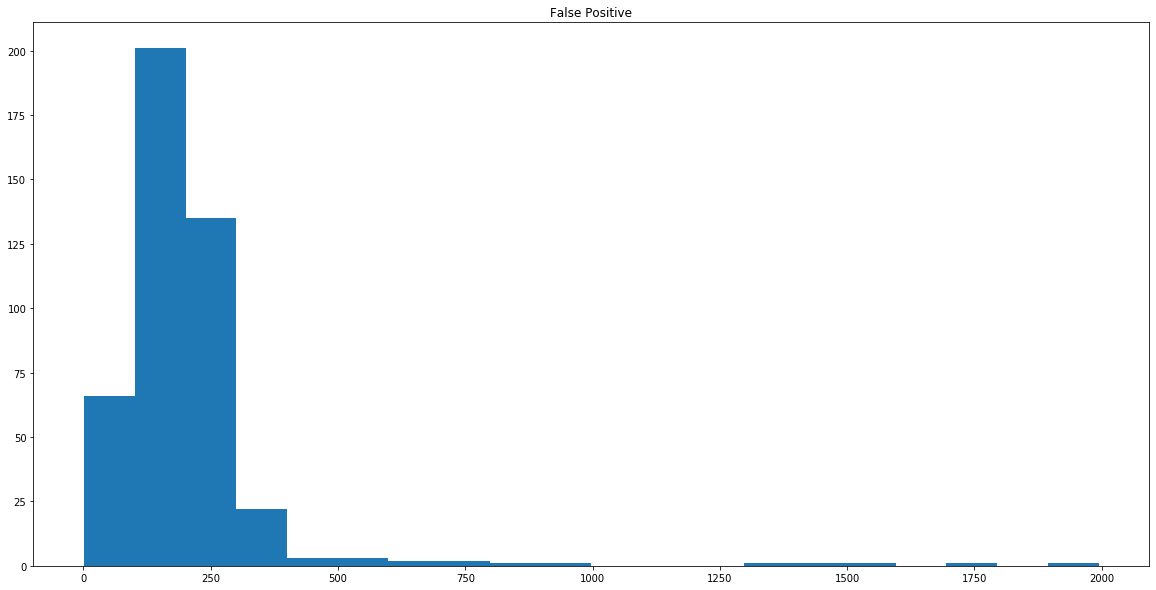

In [218]:
#histogram of amount feature of false positives
plt.figure(figsize=(20,10))
plt.hist(test_merge.loc[test_merge['error'] == -1]['amount'], bins = 20)
plt.title('False Positive')
plt.show()

In [228]:
#descriptive statistics of amount feature, grouped by model prediction and true fraud values
test_merge.groupby(['prediction', 'fraud'])['amount'].describe()

count        mean         std   min      25%     50%  \
prediction fraud                                                            
0          0      146431.0   31.309495   27.520444  0.00   13.540   26.55   
           1         296.0   74.877399   49.807423  0.03   36.395   66.19   
1          0         441.0  204.485873  188.637676  1.51  134.280  180.75   
           1        1493.0  609.638600  870.944166  2.40  241.470  367.24   

                       75%      max  
prediction fraud                     
0          0       41.7400   454.83  
           1      109.6325   237.48  
1          0      228.8400  1993.68  
           1      593.2200  7432.48

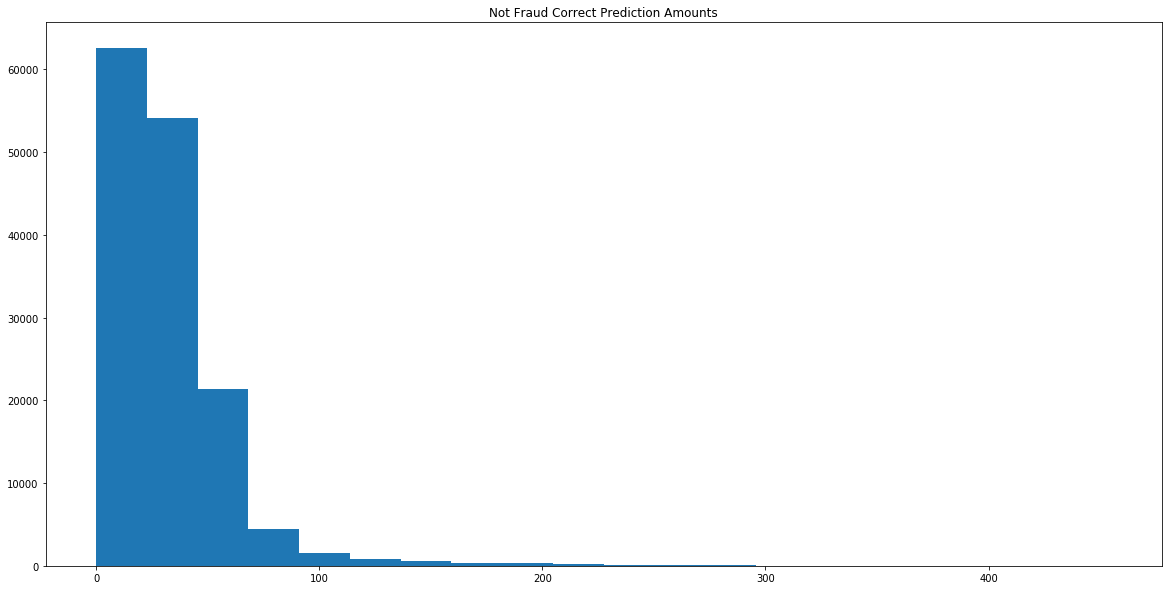

In [249]:
#histogram of amount feature of correctly predicted not fraud transactions
not_fraud_correct = test_merge.loc[(test_merge['prediction'] == 0) & (test_merge['fraud'] == 0)]['amount']

plt.figure(figsize=(20,10))
plt.hist(not_fraud_correct, bins=20)
plt.title('Not Fraud Correct Prediction Amounts')
plt.show()

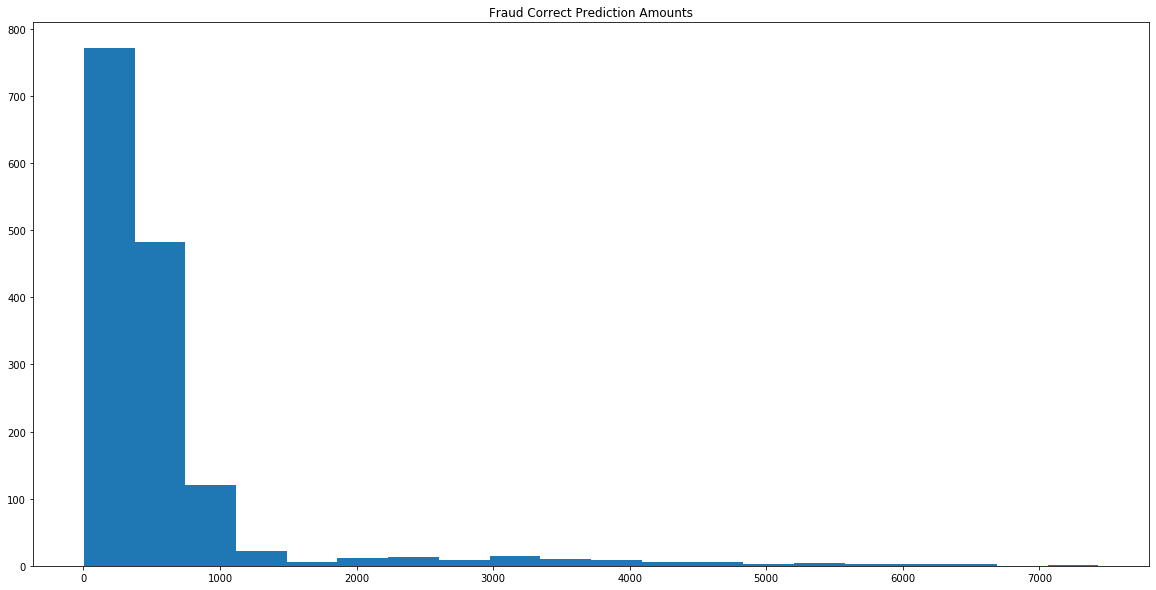

In [252]:
#histogram of amount feature of correctly predicted fraud transactions
fraud_correct = test_merge.loc[(test_merge['prediction'] == 1) & (test_merge['fraud'] == 1)]['amount']

plt.figure(figsize=(20,10))
plt.hist(fraud_correct, bins=20)
plt.title('Fraud Correct Prediction Amounts')
plt.show()

In [254]:
#close DASK client
client.close()

# Final Thoughts

For unsupersived learning clustering, the KMeans model performed extremely poorly based on very low adjusted rand scores.  I removed the fraud target feature and kept all other features and attempted to create 2 clusters with KMeans and got adjusted rand scores close to 0 on all four training datasets used after dealing with class imbalance.

With more time, I'd like to test deep learning on these same datasets and compare the model results.